In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import os

In [2]:
file_prefix = 'palomar/'

In [3]:
files = os.listdir(file_prefix)
print(files)

['calib49.fits', 'IMAGE49.fits', 'calib24.fits', 'calib65.fits', 'calib2.fits', 'calib32.fits', 'calib45.fits', 'calib12.fits', 'IMAGE45.fits', 'calib53.fits', 'calib28.fits', 'calib69.fits', 'calib68.fits', '.DS_Store', 'calib29.fits', 'calib52.fits', 'IMAGE44.fits', 'calib13.fits', 'calib44.fits', 'calib3.fits', 'calib33.fits', 'calib64.fits', 'calib72.fits', 'calib25.fits', 'IMAGE48.fits', 'calib48.fits', 'calib43.fits', 'calib14.fits', 'IMAGE43.fits', 'calib55.fits', 'calib8.fits', 'calib38.fits', 'calib18.fits', 'calib59.fits', 'calib22.fits', 'calib63.fits', 'calib34.fits', 'calib4.fits', 'calib35.fits', 'calib5.fits', 'calib62.fits', 'calib23.fits', 'calib58.fits', 'calib19.fits', 'calib9.fits', 'calib39.fits', 'calib54.fits', 'calib15.fits', 'calib42.fits', 'calib57.fits', 'calib16.fits', 'calib41.fits', 'calib36.fits', 'calib6.fits', 'calib61.fits', 'calib20.fits', 'calib21.fits', 'calib60.fits', 'calib37.fits', 'calib7.fits', 'calib40.fits', 'calib17.fits', 'calib56.fits', 'c

In [4]:
fits_image_filename = 'palomar/calib1.fits'
data = fits.open(fits_image_filename)
print(repr(data[0].header))

SIMPLE  =                    T / Java FITS: Fri May 05 12:36:46 PDT 2023        
BITPIX  =                   32                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 6244                                                  
NAXIS2  =                 6160                                                  
EXTEND  =                    T / Extensions are permitted                       
EXPTIME =                  0.0 / Exposure time (seconds)                        
SENSORW =                 6144 / sensor width                                   
SENSORH =                 6160 / sensor height                                  
AMPCCDX =                    2 / Amplifiers per CCD X                           
AMPCCDY =                    2 / Amplifiers per CCD Y                           
TIMSCRP = 'wasp_10_8_2019.acf' / Archon asf file name                           
MODULE1 = 'None    '        

# Master Bias

In [5]:
trim = np.s_[:, 50:-50]

Text(0.5, 1.0, 'Master Bias')

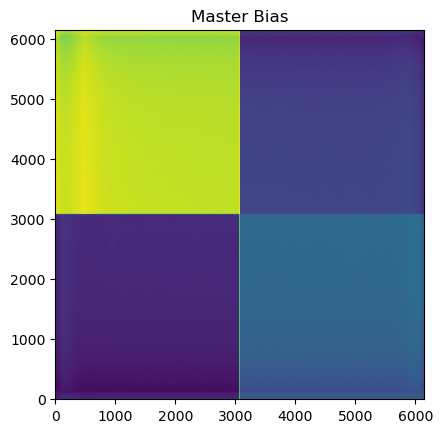

In [6]:
bias_range = range(1, 12)
biases = []
for i in bias_range:
    bias_file = file_prefix + f"calib{i}.fits"
    
    hdul = fits.open(bias_file)
    data = hdul['PRIMARY'].data[trim].astype(float)
    biases.append(data)
    
master_bias = np.median(biases, axis=0)
plt.imshow(master_bias, vmin=np.percentile(master_bias, 1), vmax=np.percentile(master_bias, 99), origin='lower')
plt.title('Master Bias')

# Master Flats

In [7]:
def make_master_flat(flat_range, plot=True):
    # TODO: how to adjust for bias?

    flats = []
    
    for i in flat_range:
        flat_file = file_prefix + f"calib{i}.fits"

        hdul = fits.open(flat_file)
        exp_time = hdul[0].header['EXPTIME']
        filt = hdul[0].header['FILTER']
        data = hdul['PRIMARY'].data[trim].astype(float)
        data -= master_bias
        data /= exp_time
        
        flats.append(data)

    master_flat = np.median(flats, axis=0)
    master_flat /= np.mean(master_flat)
    
    if plot:
        plt.imshow(master_flat, vmin=np.percentile(master_flat, 1), vmax=np.percentile(master_flat, 99), origin='lower')
        plt.title(f'Master Flat {filt}')
        plt.colorbar()
    
    return master_flat

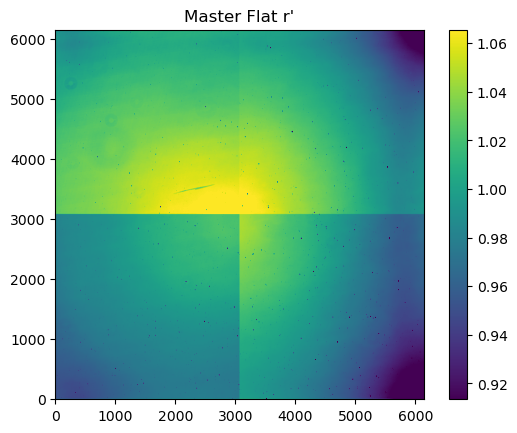

In [8]:
master_flat_r = make_master_flat(range(14, 27)) # r'

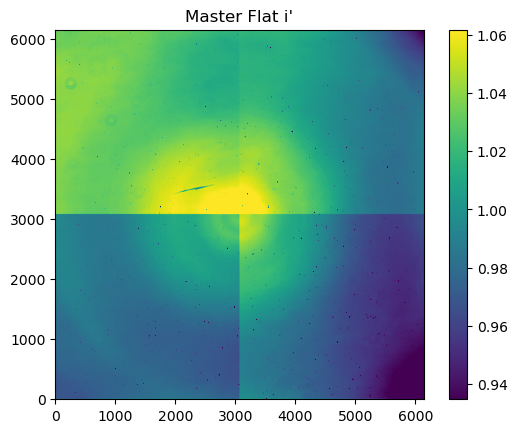

In [9]:
master_flat_i = make_master_flat(range(27, 39)) # i'

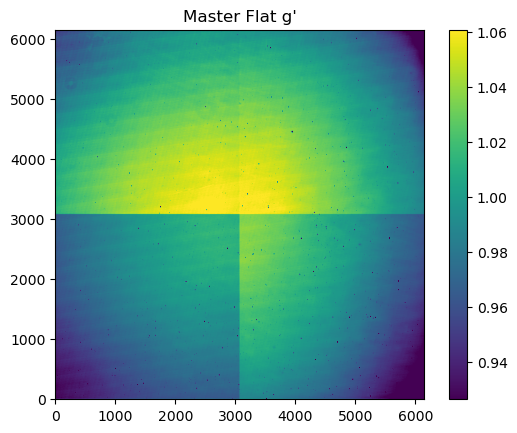

In [10]:
master_flat_g = make_master_flat(range(40, 52)) # g'

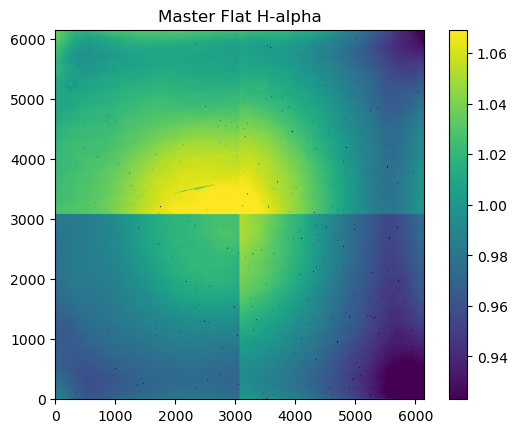

In [11]:
master_flat_halpha = make_master_flat(range(56, 67)) # h-alpha

# Image Processing

## r'

/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_1368/2367614562.py:8: RuntimeWarning: divide by zero encountered in divide
  m101_r_data = m101_r_data / master_flat_r
/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_1368/2367614562.py:8: RuntimeWarning: invalid value encountered in divide
  m101_r_data = m101_r_data / master_flat_r


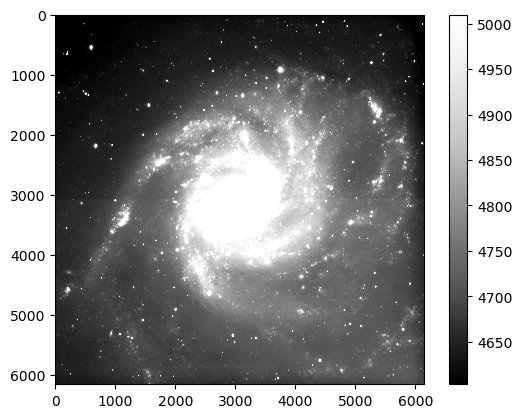

In [12]:
m101_r = file_prefix + "IMAGE44.fits"

hdul = fits.open(m101_r)
exp_time = hdul[0].header['EXPTIME']
m101_r_data = hdul['PRIMARY'].data[trim].astype(float)

m101_r_data = m101_r_data - master_bias
m101_r_data = m101_r_data / master_flat_r
# m101_r_data /= exp_time # TODO: divide by exposure time only for false color img; remove for science data analysis

plt.figure()
plt.imshow(m101_r_data, vmin=np.nanpercentile(m101_r_data, 5), vmax=np.nanpercentile(m101_r_data, 95), cmap='Greys_r')
plt.colorbar()
plt.show()

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kwargs)>

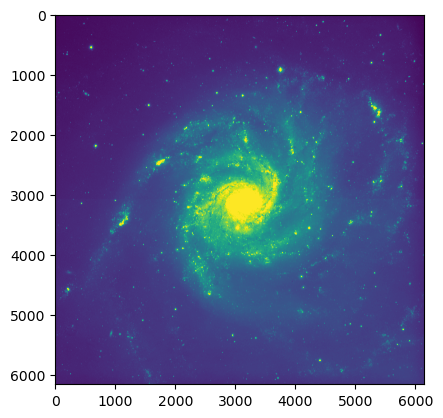

In [13]:
first_percentile = np.nanpercentile(m101_r_data, 1)
last_percentile = np.nanpercentile(m101_r_data, 99)

outliers = np.where(m101_r_data < first_percentile)
m101_r_data[outliers] = first_percentile

outliers = np.where(m101_r_data > last_percentile)
m101_r_data[outliers] = last_percentile

m101_r_counts = np.copy(m101_r_data)

# m101_r_data -= np.nanmin(m101_r_data)
# m101_r_data /= np.nanmax(m101_r_data)

nans = np.where(np.isnan(m101_r_data))
m101_r_data[nans] = np.nanmin(m101_r_data)

plt.imshow(m101_r_data)
plt.colorbar

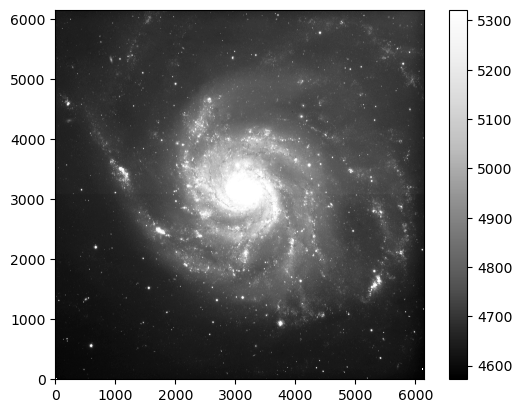

In [14]:
plt.imshow(m101_r_counts, cmap='Greys_r', origin='lower')
plt.colorbar()
hdu = fits.PrimaryHDU(m101_r_data)
hdul = fits.HDUList([hdu])
hdul.writeto('analysis_imgs/r.fits', overwrite=True)

## g'

/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_1368/450019556.py:8: RuntimeWarning: divide by zero encountered in divide
  m101_g_data = m101_g_data / master_flat_g
/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_1368/450019556.py:8: RuntimeWarning: invalid value encountered in divide
  m101_g_data = m101_g_data / master_flat_g


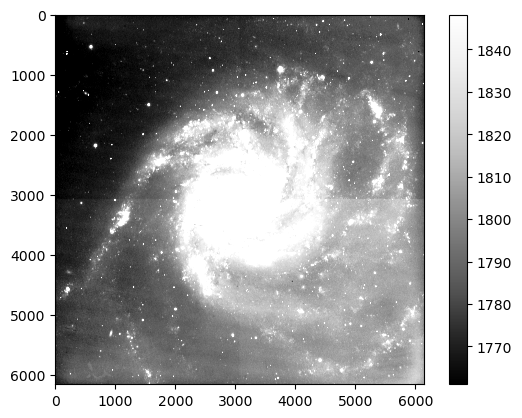

In [15]:
m101_g = file_prefix + "IMAGE43.fits"

hdul = fits.open(m101_g)
exp_time = hdul[0].header['EXPTIME']
m101_g_data = hdul['PRIMARY'].data[trim].astype(float)

m101_g_data = m101_g_data - master_bias
m101_g_data = m101_g_data / master_flat_g
# m101_g_data /= exp_time

plt.figure()
plt.imshow(m101_g_data, vmin=np.nanpercentile(m101_g_data, 10), vmax=np.nanpercentile(m101_g_data, 90), cmap='Greys_r')
plt.colorbar()
plt.show()

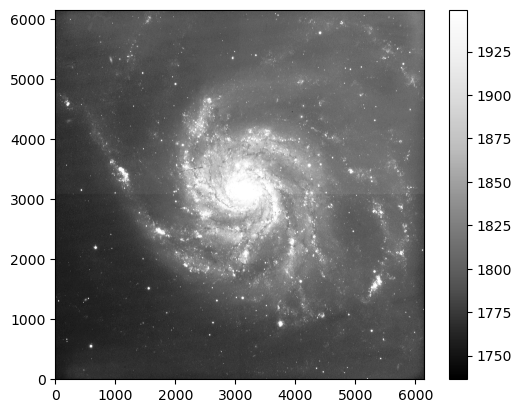

In [16]:
first_percentile = np.nanpercentile(m101_g_data, 1)
last_percentile = np.nanpercentile(m101_g_data, 99)


outliers = np.where(m101_g_data < first_percentile)
m101_g_data[outliers] = first_percentile

outliers = np.where(m101_g_data > last_percentile)
m101_g_data[outliers] = last_percentile

m101_g_counts = np.copy(m101_g_data)

nans = np.where(np.isnan(m101_g_data))
m101_g_data[nans] = np.nanmin(m101_g_data)

plt.imshow(m101_g_data, cmap='Greys_r', origin='lower')
plt.colorbar()

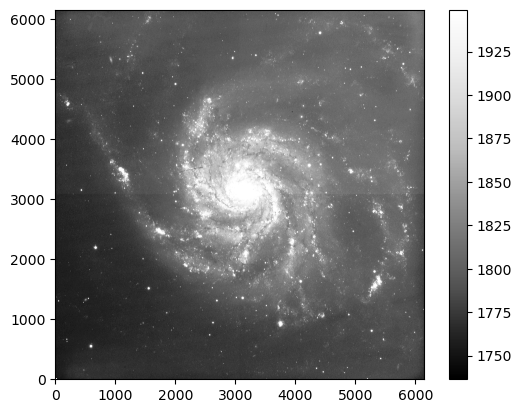

In [17]:
plt.imshow(m101_g_counts, cmap='Greys_r', origin='lower')
plt.colorbar()
hdu = fits.PrimaryHDU(m101_g_data)
hdul = fits.HDUList([hdu])
hdul.writeto('analysis_imgs/g.fits', overwrite=True)

## i'

/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_1368/2800501433.py:12: RuntimeWarning: invalid value encountered in divide
  m101_i_data = m101_i_data / master_flat_i


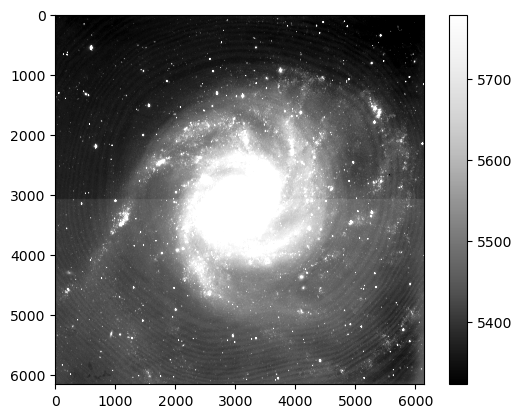

In [18]:
i_range = range(45, 48)

i_data = []
for i in i_range:
    i_file = file_prefix + f"IMAGE{i}.fits"
    
    hdul = fits.open(i_file)
    exp_time = hdul[0].header['EXPTIME']
    m101_i_data = hdul['PRIMARY'].data[trim].astype(float)

    m101_i_data = m101_i_data - master_bias
    m101_i_data = m101_i_data / master_flat_i
#     m101_i_data /= exp_time
    
    i_data.append(m101_i_data)
    
m101_i_data = np.median(i_data, axis=0)

plt.figure()
plt.imshow(m101_i_data, vmin=np.nanpercentile(m101_i_data, 5), vmax=np.nanpercentile(m101_i_data, 95), cmap='Greys_r')
plt.colorbar()
plt.show()

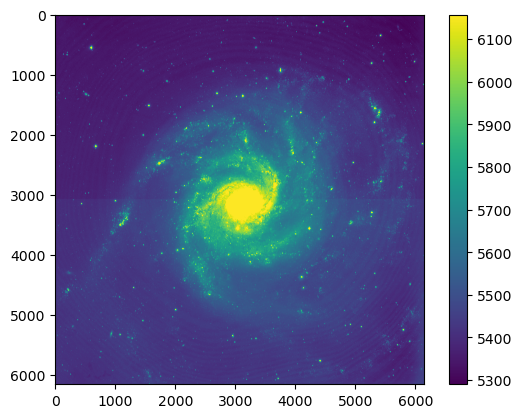

In [21]:
first_percentile = np.nanpercentile(m101_i_data, 1)
last_percentile = np.nanpercentile(m101_i_data, 99)


outliers = np.where(m101_i_data < first_percentile)
m101_i_data[outliers] = first_percentile

outliers = np.where(m101_i_data > last_percentile)
m101_i_data[outliers] = last_percentile

nans = np.where(np.isnan(m101_i_data))
m101_i_data[nans] = np.nanmin(m101_i_data)

m101_i_counts = np.copy(m101_i_data)

plt.imshow(m101_i_data)
plt.colorbar()

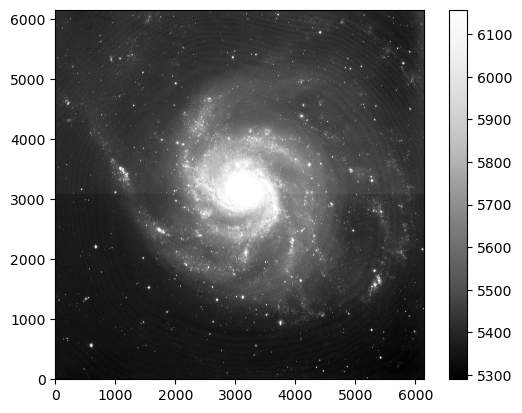

In [22]:
plt.imshow(m101_i_counts, cmap='Greys_r', origin='lower')
plt.colorbar()
hdu = fits.PrimaryHDU(m101_i_data)
hdul = fits.HDUList([hdu])
hdul.writeto('analysis_imgs/i.fits', overwrite=True)

## h-alpha

/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_1368/1144635683.py:12: RuntimeWarning: divide by zero encountered in divide
  m101_halpha_data = m101_halpha_data / master_flat_halpha
/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_1368/1144635683.py:12: RuntimeWarning: invalid value encountered in divide
  m101_halpha_data = m101_halpha_data / master_flat_halpha


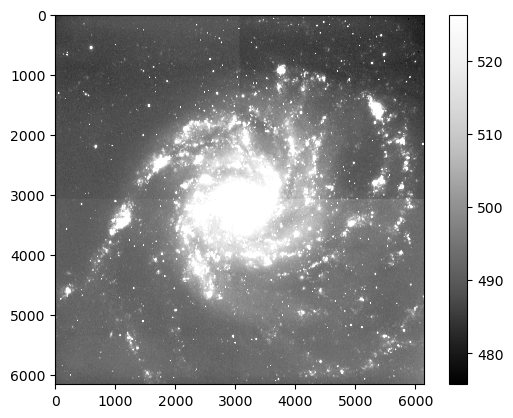

In [23]:
halpha_range = range(48, 51)

halpha_data = []
for i in halpha_range:
    halpha_file = file_prefix + f"IMAGE{i}.fits"
    
    hdul = fits.open(halpha_file)
    exp_time = hdul[0].header['EXPTIME']
    m101_halpha_data = hdul['PRIMARY'].data[trim].astype(float)

    m101_halpha_data = m101_halpha_data - master_bias
    m101_halpha_data = m101_halpha_data / master_flat_halpha
#     m101_halpha_data /= exp_time
    
    halpha_data.append(m101_halpha_data)
    
m101_halpha_data = np.median(halpha_data, axis=0)

plt.figure()
plt.imshow(m101_halpha_data, vmin=np.nanpercentile(m101_halpha_data, 5), vmax=np.nanpercentile(m101_halpha_data, 95), cmap='Greys_r')
plt.colorbar()
plt.show()

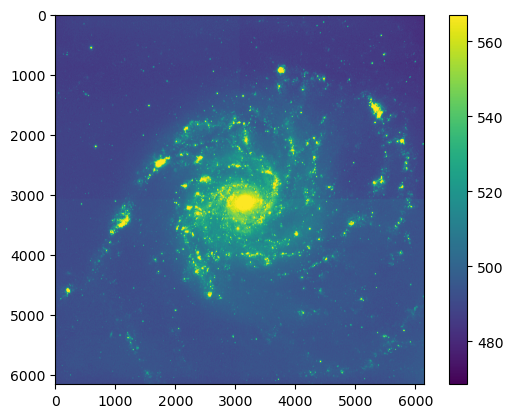

In [26]:
first_percentile = np.nanpercentile(m101_halpha_data, 1)
last_percentile = np.nanpercentile(m101_halpha_data, 99)

outliers = np.where(m101_halpha_data < first_percentile)
m101_halpha_data[outliers] = first_percentile

outliers = np.where(m101_halpha_data > last_percentile)
m101_halpha_data[outliers] = last_percentile

m101_halpha_counts = np.copy(m101_halpha_data)

nans = np.where(np.isnan(m101_halpha_data))
m101_halpha_data[nans] = np.nanmin(m101_halpha_data)

plt.imshow(m101_halpha_data)
plt.colorbar()

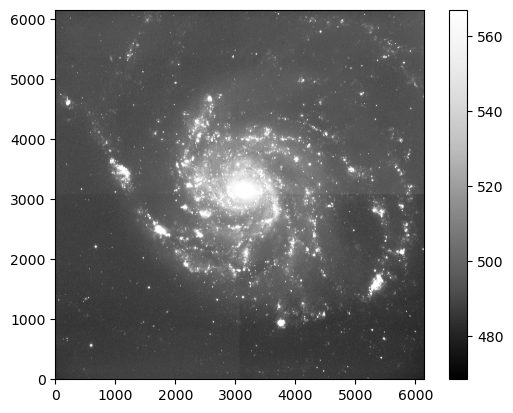

In [27]:
plt.imshow(m101_halpha_counts, cmap='Greys_r', origin='lower')
plt.colorbar()
hdu = fits.PrimaryHDU(m101_halpha_data)
hdul = fits.HDUList([hdu])
hdul.writeto('analysis_imgs/halpha.fits', overwrite=True)

# False Color Image

In [ ]:
# rgb image with imshow
# shape: (x, y, 3) --> last axis is channel order
# float arr have to go from 0 to 1, int arr go from 0 to 255
# remove outliers (set less than first percentile to first percentile)
# could do 4 channels with transparency adjusted by halpha

# stacked = m101_r_data + m101_g_data + m101_i_data + m101_halpha_data


rgbArray = np.zeros((6160,6144,3), 'float')
rgbArray[..., 0] = m101_halpha_data
rgbArray[..., 1] = m101_r_data
rgbArray[..., 2] = m101_g_data

# img_data = np.array([m101_r_data, m101_g_data, m101_halpha_data]).reshape((6160, 6244, 3))
plt.figure(figsize=(10, 10))
plt.imshow(rgbArray)
plt.title("M101: Pinwheel Galaxy")

# Photometric Calibrations

In [60]:
# star 1 at pixel coordinate (1823.71, 2291.56)
def find_star_center(full_img, zoomed, cols, rows, plot_means=True):
    # image in counts, dividing by exposure time gives counts/s
    # Finding center of star
    col_start = cols[0]
    col_end = cols[-1]
    row_start = rows[0]
    row_end = rows[-1]
    zoomed = full_img[col_start:col_end + 1, row_start:row_end + 1]

    row_mean = np.mean(zoomed, axis=0)
    col_mean = np.mean(zoomed, axis=1)
    x_coord = np.argmax(row_mean) + row_start
    y_coord = np.argmax(col_mean) + col_start
    
    if plot_means:
        plt.figure()
        plt.xlim((row_start, row_end))
        plt.ylim((col_start, col_end))
        plt.imshow(full_img, cmap='Greys_r')
        plt.colorbar()
        plt.title("I-filter Star Calibration 1")
        plt.plot(x_coord, y_coord, 'x', color='blue')

    print("x-coordinate of center: " + str(x_coord))
    print("y-coordinate of center: " + str(y_coord))
    
    return (x_coord, y_coord)

def create_aperture(full_img, plot=True):
    y, x = np.mgrid[0:full_img.shape[0], 0:full_img.shape[1]]
    distances = np.sqrt((x - x_coord) ** 2 + (y - y_coord) ** 2)
    
    return distances

n = 50

def calc_counts_v_radius(full_img, max_radius):
    aperture_counts = []
    annulus_counts = []
    n_pixels = []

    for radius in range(max_radius):
        masked_data = np.ma.array(full_img, mask=(distances > radius))
        aperture_counts.append(masked_data.sum())
        n_pixels.append(masked_data.count())
        masked_data = np.ma.array(full_img, mask=(distances < 2 * radius) | (distances > 3 * radius))
        annulus_counts.append(np.ma.median(masked_data))
    
    return aperture_counts, annulus_counts, n_pixels

def plot_counts_v_radius(full_img, aperture, annulus, optimal_r, max_radius):
    plt.figure(figsize=(5, 3))
    plt.plot(range(max_radius), aperture)
    plt.axvline(optimal_r, color='red')
    plt.yscale('log')
    plt.title('Counts/sec vs. Aperture Radius')
    plt.xlabel('Aperture Radius (pixels)')
    plt.ylabel('log (counts / sec) in aperture')

    plt.figure(figsize=(5, 3))
    plt.plot(range(max_radius), annulus)
    plt.axvline(optimal_r, color='red')
    plt.yscale('log')
    plt.title('Background/Annulus Median vs. Aperture Radius')
    plt.xlabel('Aperture Radius (pixels)')
    plt.ylabel('log \n(annulus background median in counts/sec)')
    
    plt.show()
    
def calculate_brightness(aperture_r, flux, prnt=True):
    aperture_sum = aperture_counts[aperture_r - 1]
    median = annulus_counts[aperture_r - 1]
    median *= n_pixels[aperture_r - 1]
    aperture_sum -= median

    if prnt:
        print("Brightness in counts/sec = " + str(aperture_sum))
        print("Calibration factor = " + str(flux / aperture_sum) + " (W / (m^2 * micrometers)) / (counts / sec)")
    
    return (aperture_sum, flux / aperture_sum)

## i' filter

In [3]:
fits_image_filename = 'analysis_imgs/i.fits'
data = fits.open(fits_image_filename)
img = data['PRIMARY'].data.astype('float')

## Star 1

x-coordinate of center: 1819
y-coordinate of center: 2286


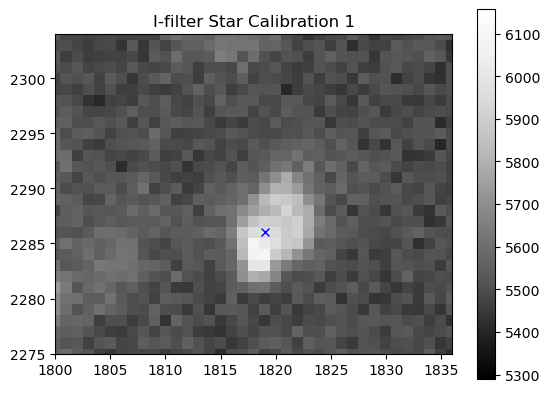

In [4]:
zoomed = img[2275:2305, 1800:1837]
x_coord, y_coord = find_star_center(img, zoomed, range(2275, 2305), range(1800, 1837))

## Star 2

x-coordinate of center: 2578
y-coordinate of center: 750


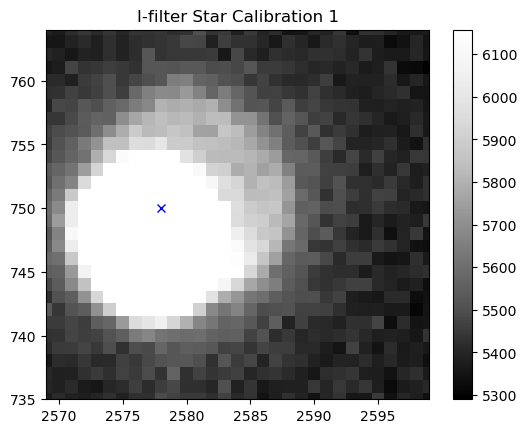

In [5]:
zoomed = img[2569:2600, 735:765]
x_coord, y_coord = find_star_center(img, zoomed, range(735, 765), range(2569, 2600))
distances = create_aperture(img)

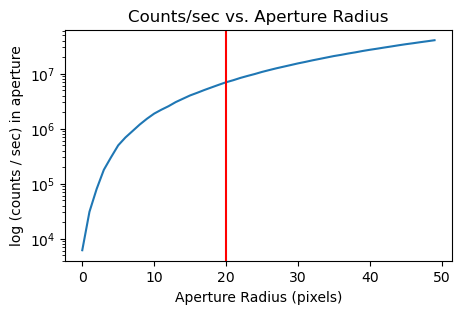

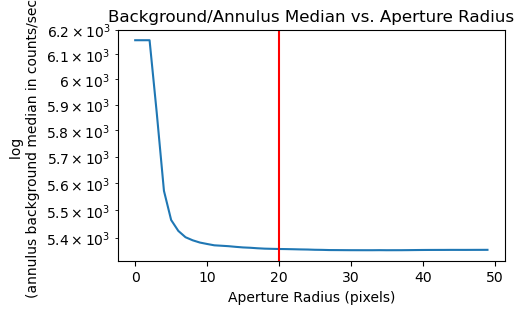

In [6]:
aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
plot_counts_v_radius(img, aperture_counts, annulus_counts, 20, n)

In [7]:
i_mag = 19.5933
f_0i = 8.318e-9

i_flux = 10 ** (i_mag / (-2.5)) * f_0i
counts, i_cal = calculate_brightness(20, i_flux)

Brightness in counts/sec = 242098.29123016354
Calibration factor = 4.996975175324027e-22 (W / (m^2 * micrometers)) / (counts / sec)


## g' filter

In [8]:
fits_image_filename = 'analysis_imgs/g.fits'
data = fits.open(fits_image_filename)
img = data['PRIMARY'].data.astype('float')

x-coordinate of center: 1817
y-coordinate of center: 2272


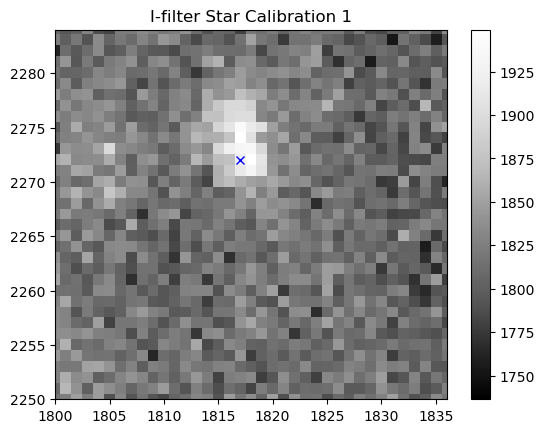

In [9]:
zoomed = img[2250:2285, 1800:1837]
x_coord, y_coord = find_star_center(img, zoomed, range(2250, 2285), range(1800, 1837))

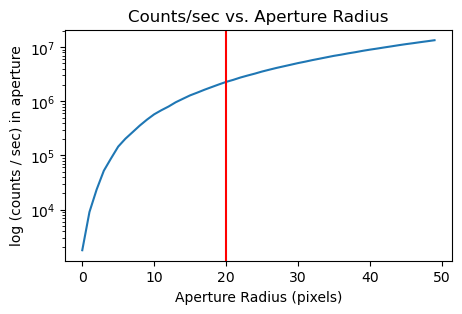

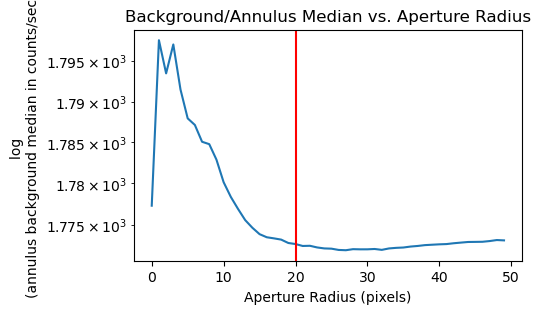

In [10]:
aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
plot_counts_v_radius(img, aperture_counts, annulus_counts, 20, n)

In [11]:
# TODO: change all these values for g' and for the star used for cals
g_mag = 18.8401
f_0g = 5.41e-8 # TODO: check if this value is correct?

g_flux = 10 ** (g_mag / (-2.5)) * f_0g
counts, g_cal = calculate_brightness(20, g_flux)

Brightness in counts/sec = 45697.21571394359
Calibration factor = 3.4456211563683286e-20 (W / (m^2 * micrometers)) / (counts / sec)


# h-alpha

In [12]:
fits_image_filename = 'analysis_imgs/halpha.fits'
data = fits.open(fits_image_filename)
img = data['PRIMARY'].data.astype('float')

x-coordinate of center: 1807
y-coordinate of center: 2268


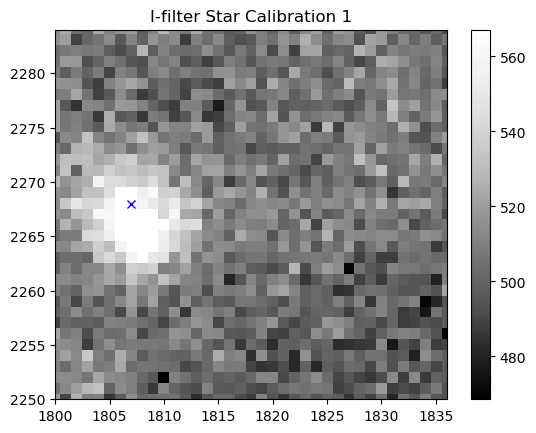

In [13]:
zoomed = img[2250:2285, 1800:1837]
x_coord, y_coord = find_star_center(img, zoomed, range(2250, 2285), range(1800, 1837))

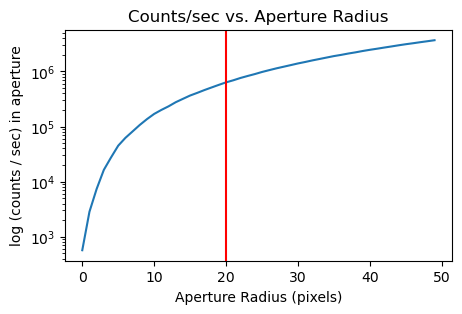

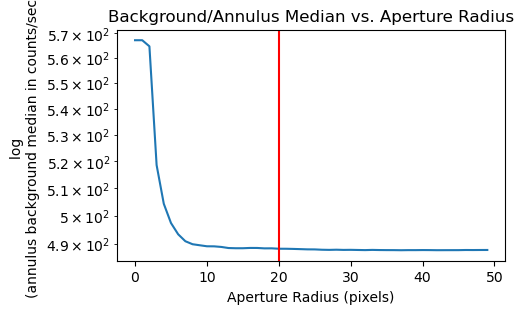

In [14]:
aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
plot_counts_v_radius(img, aperture_counts, annulus_counts, 20, n)

In [15]:
r_mag = 20.7132
f_0r = 2.5e-8 # TODO: check if this is correct (img tutorial)
f_0h = f_0r * 100 / 1470 # TODO: check if this value is correct?

r_flux_from_mag = f_0r * 10 ** (r_mag / -2.5)
halpha_flux = r_flux_from_mag * 100 / 1470

halpha_mag = -2.5 * np.log10(halpha_flux / f_0h)
counts, halpha_cal = calculate_brightness(20, halpha_flux)

Brightness in counts/sec = 20786.016445333138
Calibration factor = 4.242007259172468e-22 (W / (m^2 * micrometers)) / (counts / sec)


# r' filter

In [42]:
fits_image_filename = 'analysis_imgs/r.fits'
data = fits.open(fits_image_filename)
img = data['PRIMARY'].data.astype('float')

x-coordinate of center: 1819
y-coordinate of center: 2279


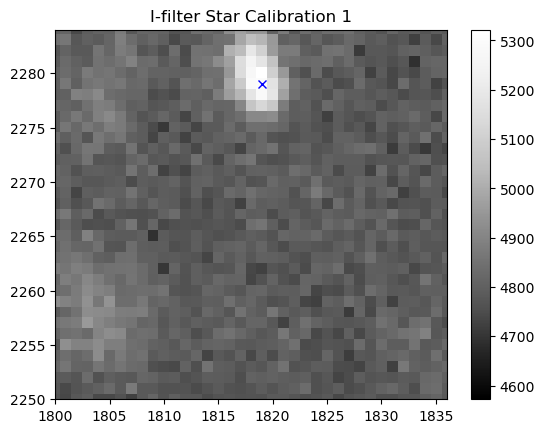

In [43]:
zoomed = img[2250:2285, 1800:1837]
x_coord, y_coord = find_star_center(img, zoomed, range(2250, 2285), range(1800, 1837))

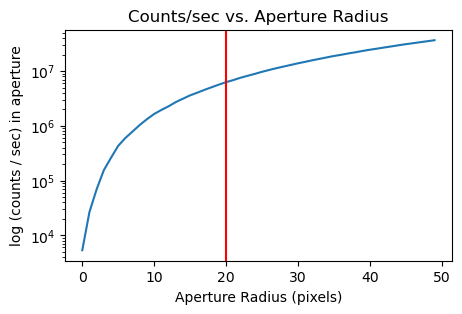

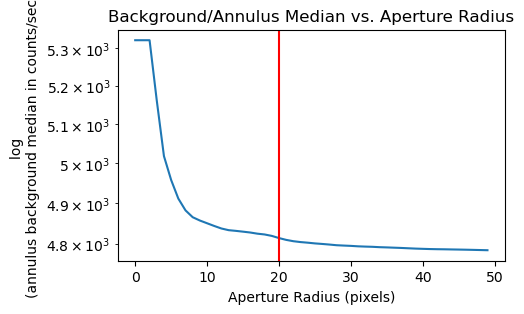

In [44]:
aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
plot_counts_v_radius(img, aperture_counts, annulus_counts, 20, n)

In [45]:
r_mag = 20.7132
f_0r = 2.5e-8 # TODO: check if this is correct (img tutorial)

r_flux = 10 ** (r_mag / (-2.5)) * f_0r
counts, r_cal = calculate_brightness(20, r_flux)

Brightness in counts/sec = 209864.71250795294
Calibration factor = 6.176189148099344e-22 (W / (m^2 * micrometers)) / (counts / sec)


## Calculating upper bound for supernova region

x-coordinate of center: 1877
y-coordinate of center: 2370
Coordinates: (1877, 2370)


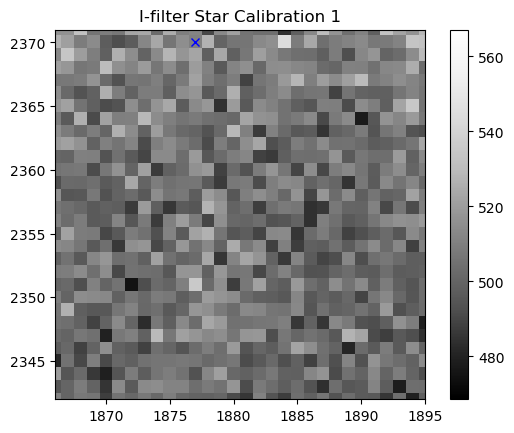

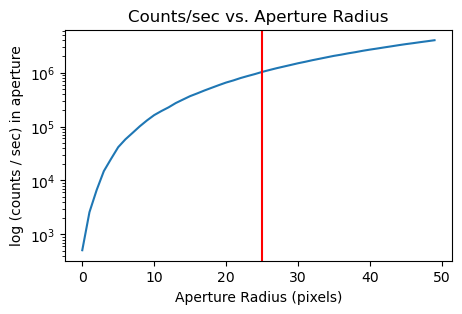

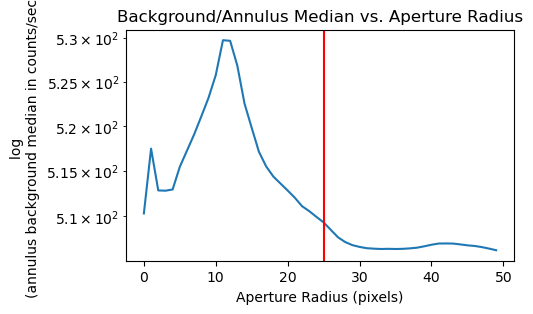

In [44]:
fits_image_filename = 'analysis_imgs/i.fits'
data = fits.open(fits_image_filename)
img = data['PRIMARY'].data.astype('float')

zoomed = img[2342:2372, 1866:1896]
x_coord, y_coord = find_star_center(img, zoomed, range(2342, 2372), range(1866, 1896))

distances = create_aperture(img, plot=False)

n = 50
aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
print(f"Coordinates: ({x_coord}, {y_coord})")
plot_counts_v_radius(img, aperture_counts, annulus_counts, 25, n)

In [45]:
optimal_r = 20
counts, _ = calculate_brightness(optimal_r, i_flux, prnt=False)
brightness = counts * i_cal
print(f"Brightness = {brightness} W/ m^2 * micrometers\n\n")


Brightness = 2.5589281734003596e-18 W/ m^2 * micrometers




In [46]:
# convert flux to magnitude
i_flux = 10 ** (i_mag / (-2.5)) * f_0i
magnitude = -2.5 * np.log10(brightness / f_0i)
print(f"Magnitude = {magnitude}")

Magnitude = 23.779902050475137


## Subtracting r' and h-alpha filters

In [52]:
# m101_r_data, m101_halpha_data
m101_r_data -= np.nanmin(m101_r_data)
m101_r_data /= np.nanmax(m101_r_data)

m101_halpha_data -= np.nanmin(m101_halpha_data)
m101_halpha_data /= np.nanmax(m101_halpha_data)
m101_subtracted = abs(np.subtract(m101_halpha_data, m101_r_data))

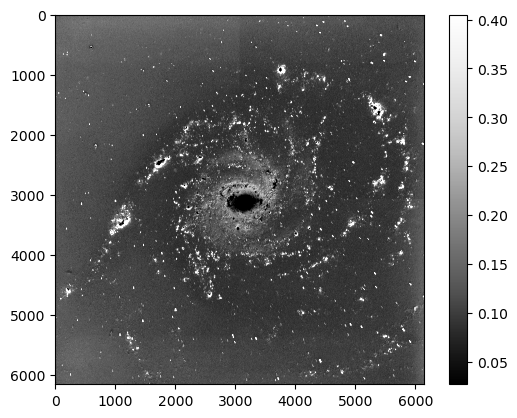

In [53]:
plt.imshow(m101_subtracted, vmin=np.nanpercentile(m101_subtracted, 15), vmax=np.nanpercentile(m101_subtracted, 99), cmap='Greys_r')
plt.colorbar()


In [54]:
hdu = fits.PrimaryHDU(m101_subtracted)
hdul = fits.HDUList([hdu])
hdul.writeto('analysis_imgs/m101_subtracted.fits', overwrite=True)

In [ ]:
# fraction of galaxy under going massive star formation?
# should we compare the total counts?

# Finding Flux of Stars Across Galaxy

In [67]:
star_y = [2029, 2415, 2697, 2377, 2685, 3572, 4008, 3684, 3878, 4278, 4426, 4622, 4804, 4540, 2572, 2868, 2700, 2133, 4177, 3415, 2496, 3505, 2395, 4277, 4030, 3828, 3149]
star_x = [2111, 2387, 2481, 2983, 3011, 3307, 3661, 3897, 3825, 3339, 3585, 3695, 4011, 4289, 3734, 3472, 2099, 3905, 2472, 2856, 3728, 1948, 4048, 3108, 1698, 1623, 3859]



In [55]:
def calculate_star_flux(star_y, star_x, flux, cal, img):
    centers = []
    brightness_lst = []
    for center_x, center_y in zip(star_x, star_y):
        width = 20

        zoomed = img[center_x - width:center_x + width, center_y-width:center_y + width]
        x_coord, y_coord = find_star_center(img, zoomed, range(center_x - width, center_x + width), range(center_y - width, center_y + width), plot_means=False)
        centers.append((x_coord, y_coord))

        distances = create_aperture(img, plot=False)

        n = 50
        optimal_r = 25

        aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
        plot_counts_v_radius(img, aperture_counts, annulus_counts, 25, n)

        counts, _ = calculate_brightness(optimal_r, flux, prnt=False)
        brightness = counts * cal
        brightness_lst.append(brightness)
        
    return brightness_lst

## i' filter

In [71]:
fits_image_filename = 'analysis_imgs/i.fits'
data = fits.open(fits_image_filename)
img = data['PRIMARY'].data.astype('float')

x-coordinate of center: 2186
y-coordinate of center: 1909


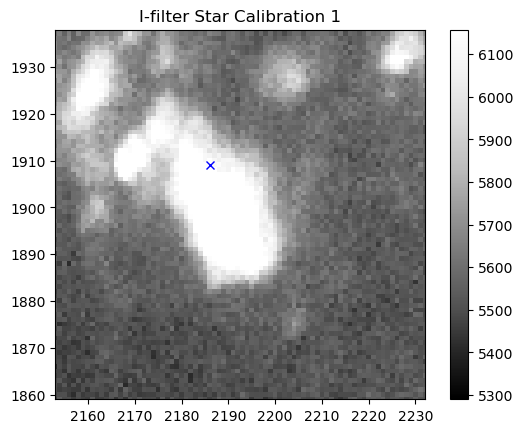

In [69]:
center_y = 2193
center_x = 1899
width = 40

zoomed = img[center_x - width:center_x + width, center_y-width:center_y + width]
x_coord, y_coord = find_star_center(img, zoomed, range(center_x - width, center_x + width), range(center_y - width, center_y + width))


In [70]:
distances = create_aperture(img, plot=False)

n = 50
optimal_r = 25

aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
plot_counts_v_radius(img, aperture_counts, annulus_counts, 25, n)

counts, _ = calculate_brightness(optimal_r, i_flux, prnt=False)
brightness = counts * i_cal

print(f"Brightness = {brightness} W/ m^2 * micrometers\n\n")

KeyboardInterrupt: 

x-coordinate of center: 2026
y-coordinate of center: 2121


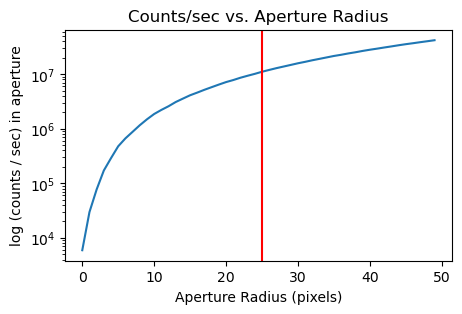

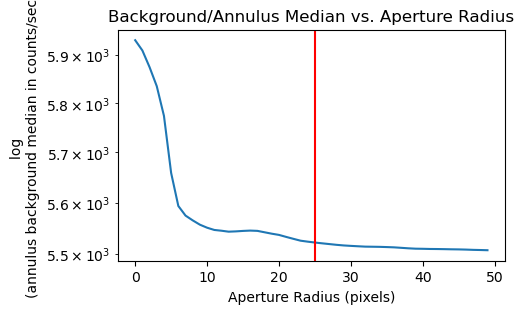

Brightness = 1.22198073042852e-16 W/ m^2 * micrometers


x-coordinate of center: 2416
y-coordinate of center: 2390


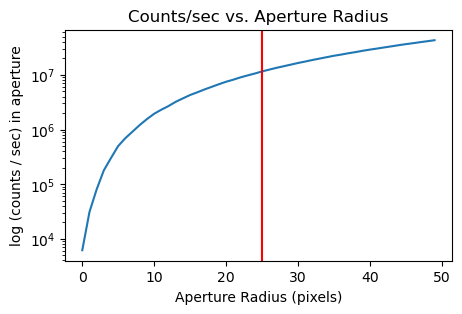

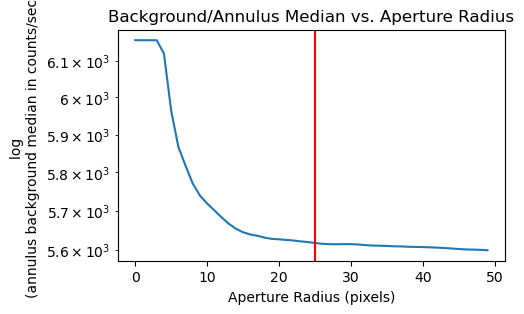

Brightness = 2.616917971130114e-16 W/ m^2 * micrometers


x-coordinate of center: 2697
y-coordinate of center: 2483


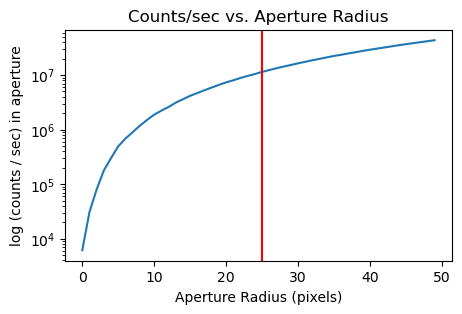

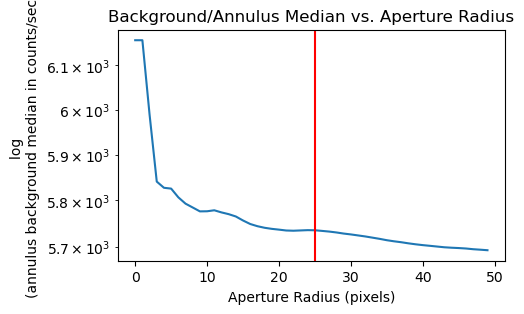

Brightness = 7.854649487062685e-17 W/ m^2 * micrometers


x-coordinate of center: 2378
y-coordinate of center: 2988


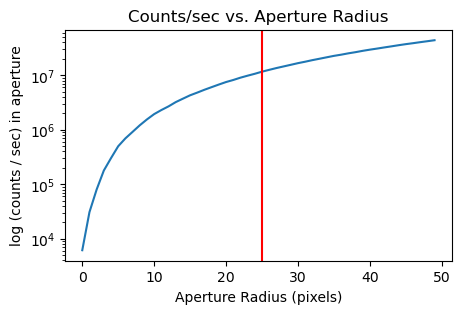

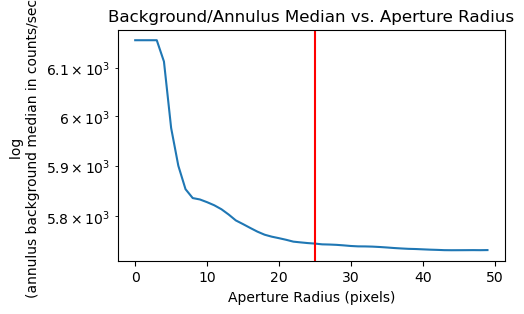

Brightness = 1.6452027406431902e-16 W/ m^2 * micrometers


x-coordinate of center: 2665
y-coordinate of center: 3010


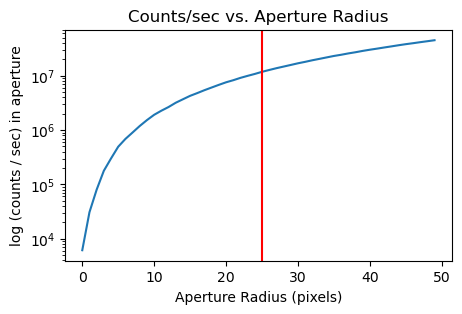

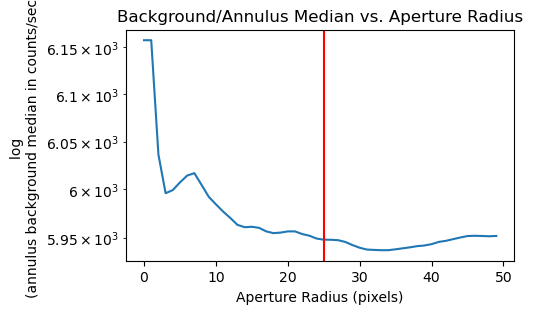

Brightness = 6.323872855472384e-17 W/ m^2 * micrometers


x-coordinate of center: 3571
y-coordinate of center: 3296


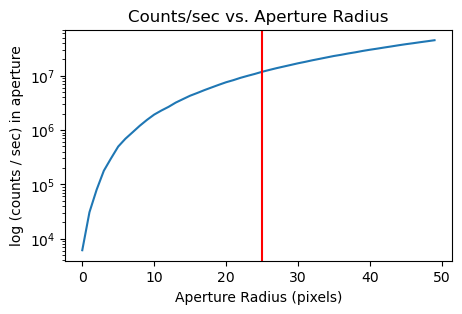

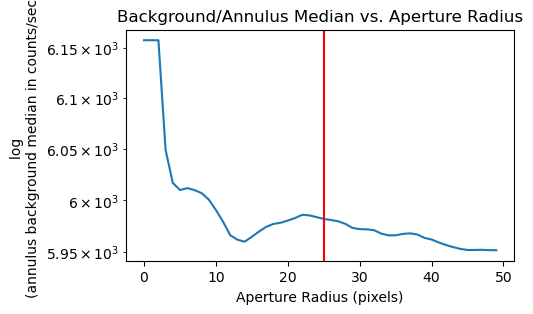

Brightness = 3.1889957902977176e-17 W/ m^2 * micrometers


x-coordinate of center: 4009
y-coordinate of center: 3664


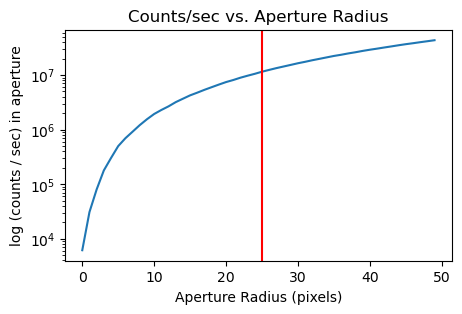

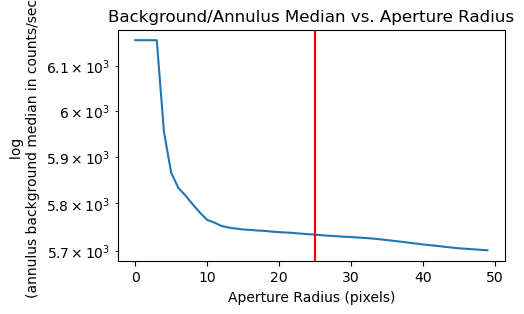

Brightness = 1.2712185474498508e-16 W/ m^2 * micrometers


x-coordinate of center: 3683
y-coordinate of center: 3893


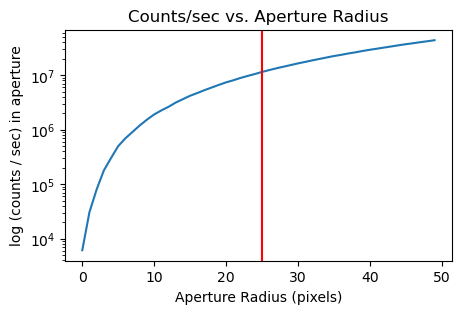

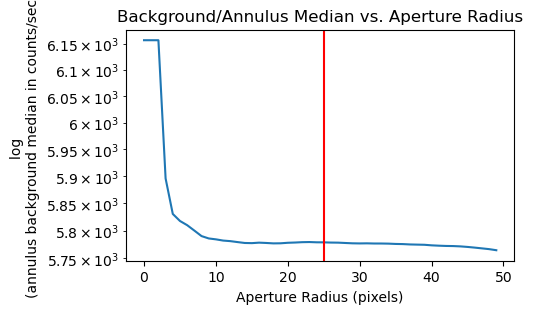

Brightness = 4.977212928377625e-17 W/ m^2 * micrometers


x-coordinate of center: 3876
y-coordinate of center: 3823


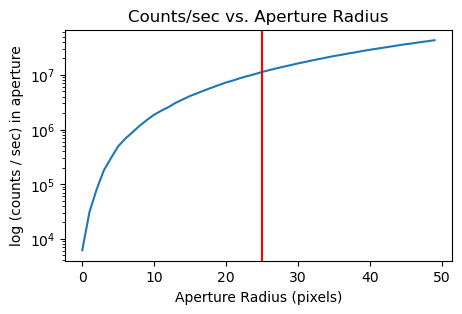

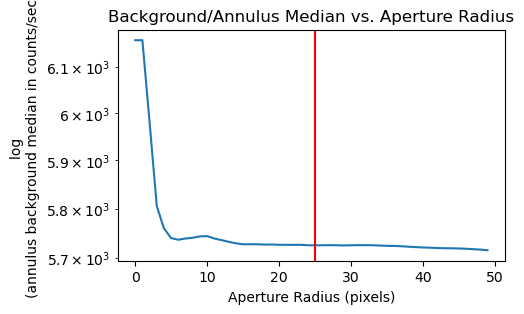

Brightness = 4.0047201329603927e-17 W/ m^2 * micrometers


x-coordinate of center: 4277
y-coordinate of center: 3342


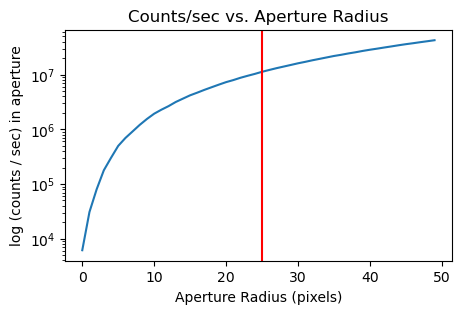

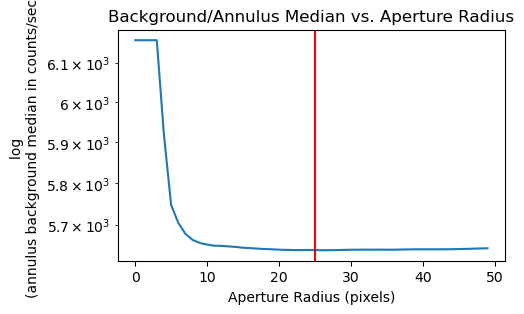

Brightness = 1.1385336123274495e-16 W/ m^2 * micrometers


x-coordinate of center: 4426
y-coordinate of center: 3586


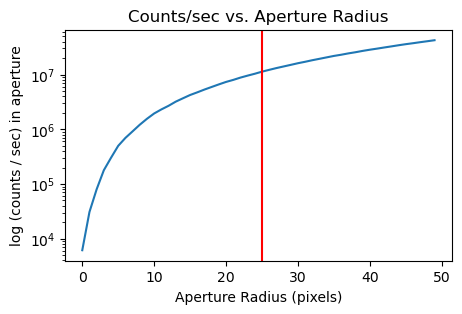

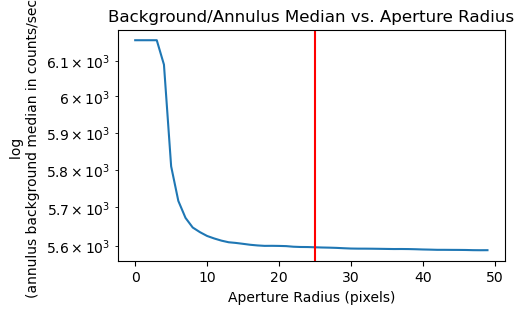

Brightness = 1.654078282005977e-16 W/ m^2 * micrometers


x-coordinate of center: 4622
y-coordinate of center: 3696


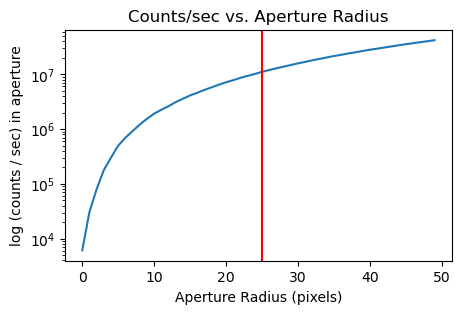

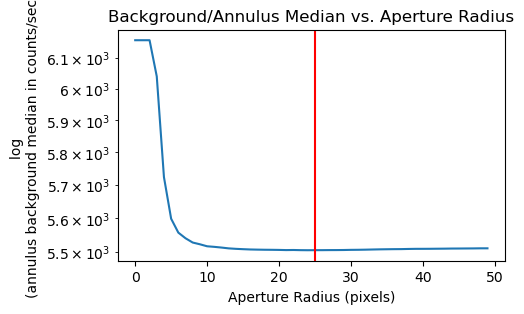

Brightness = 1.1537476239400904e-16 W/ m^2 * micrometers


x-coordinate of center: 4804
y-coordinate of center: 4011


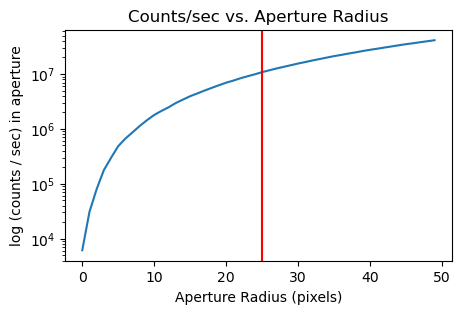

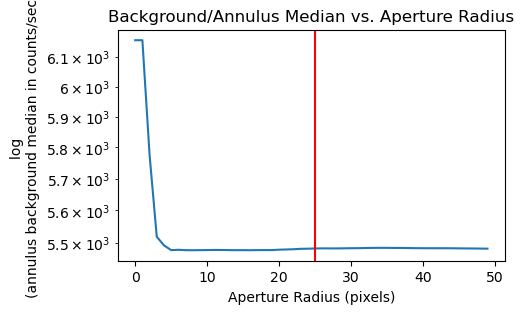

Brightness = 2.509433192083753e-17 W/ m^2 * micrometers


x-coordinate of center: 4538
y-coordinate of center: 4288


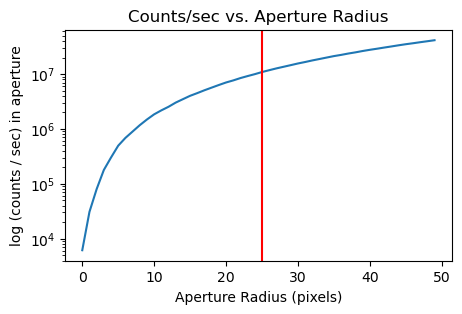

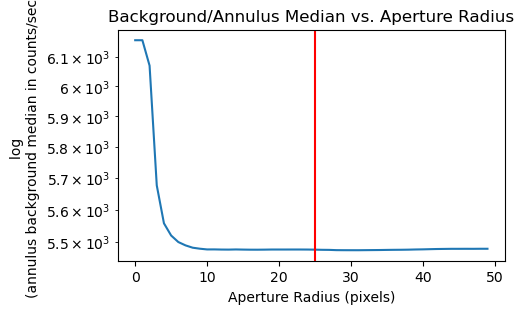

Brightness = 6.958544754232667e-17 W/ m^2 * micrometers


x-coordinate of center: 2566
y-coordinate of center: 3733


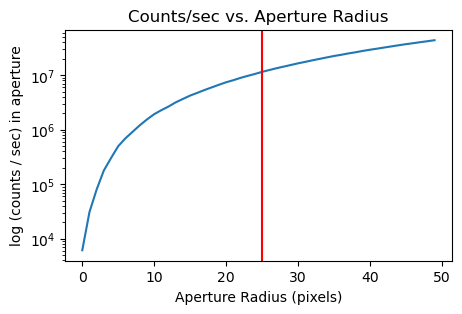

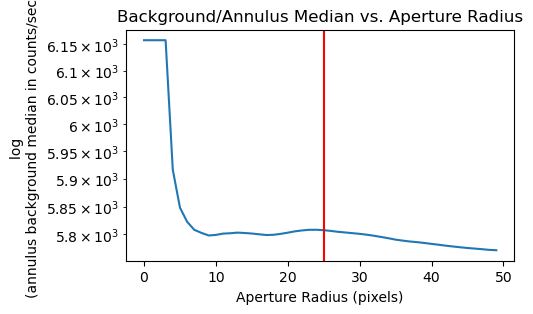

Brightness = 5.119442076610577e-17 W/ m^2 * micrometers


x-coordinate of center: 2868
y-coordinate of center: 3473


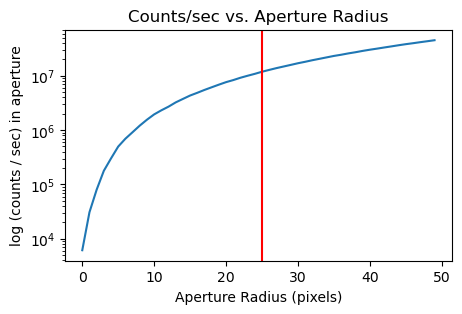

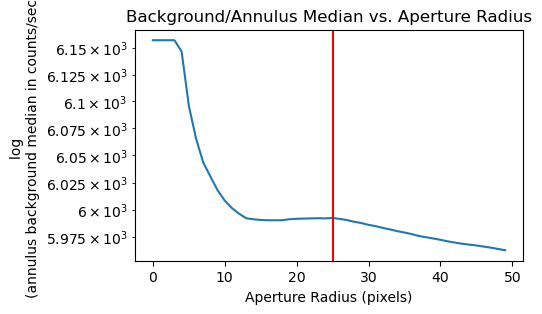

Brightness = 6.630276101390879e-17 W/ m^2 * micrometers


x-coordinate of center: 2697
y-coordinate of center: 2100


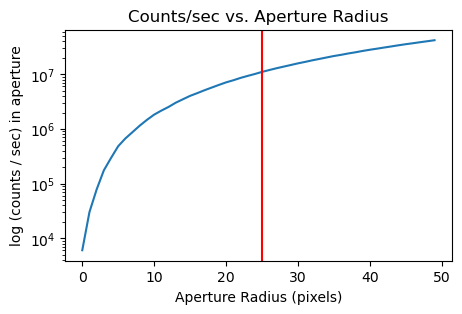

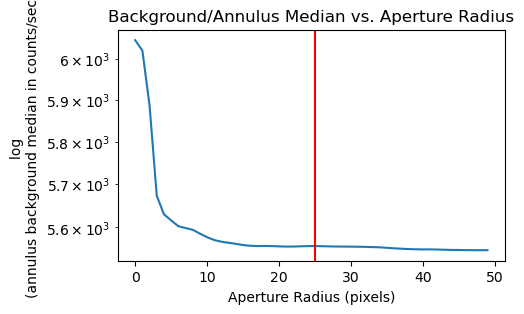

Brightness = 7.902951249535318e-17 W/ m^2 * micrometers


x-coordinate of center: 2131
y-coordinate of center: 3908


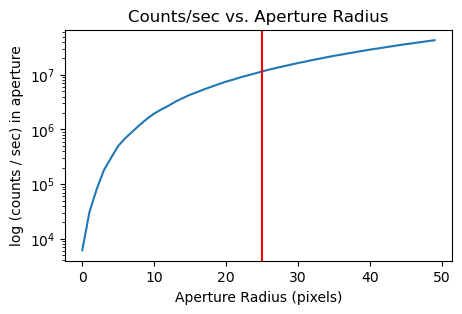

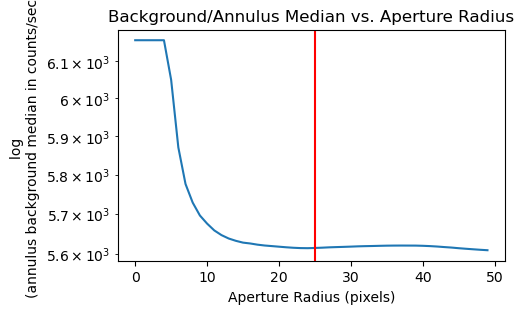

Brightness = 2.396975985562975e-16 W/ m^2 * micrometers


x-coordinate of center: 4157
y-coordinate of center: 2463


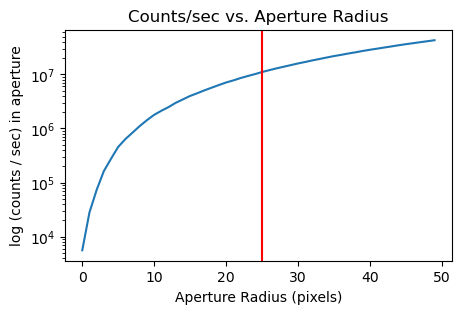

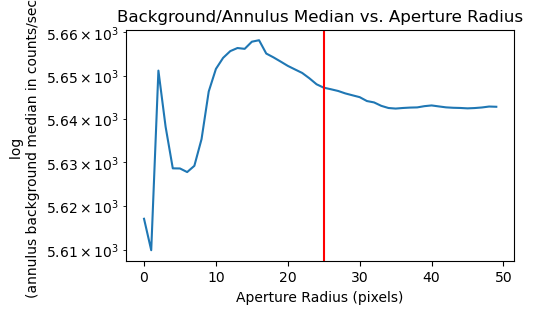

Brightness = -1.0492835564613553e-17 W/ m^2 * micrometers


x-coordinate of center: 3414
y-coordinate of center: 2859


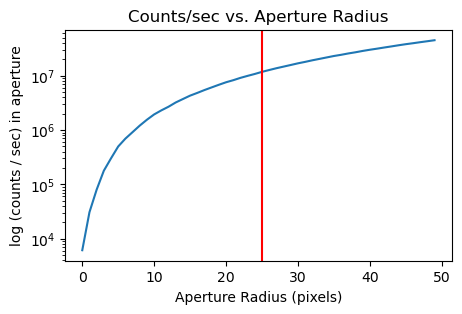

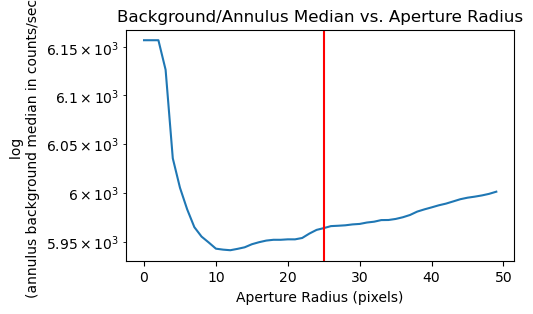

Brightness = 3.0722123298910485e-17 W/ m^2 * micrometers


x-coordinate of center: 2496
y-coordinate of center: 3728


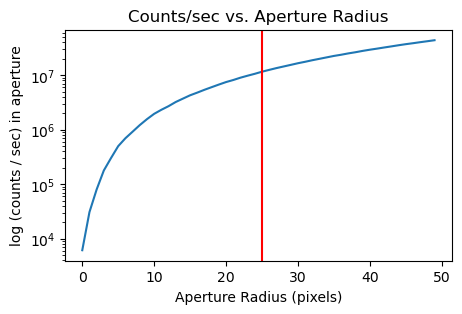

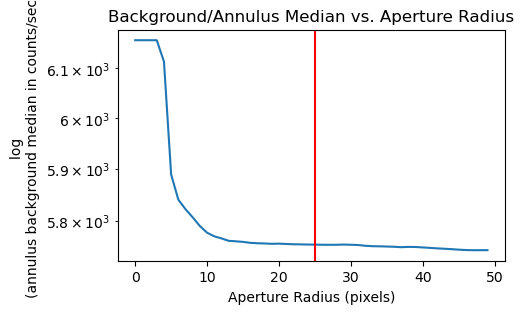

Brightness = 1.2707756895516798e-16 W/ m^2 * micrometers


x-coordinate of center: 3504
y-coordinate of center: 1948


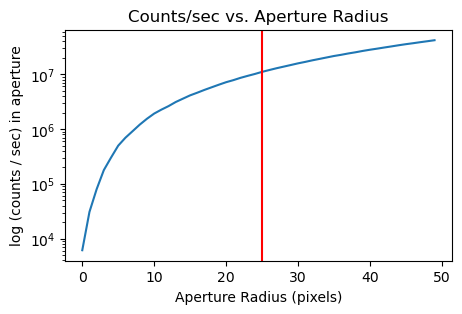

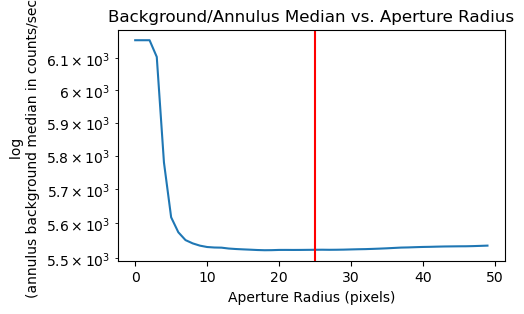

Brightness = 1.159188637192099e-16 W/ m^2 * micrometers


x-coordinate of center: 2395
y-coordinate of center: 4050


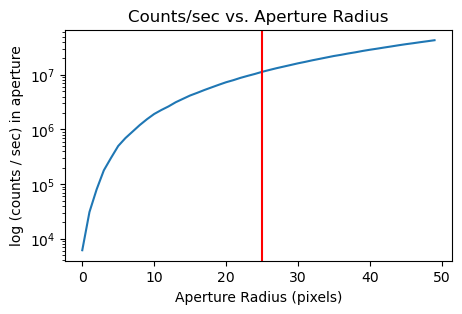

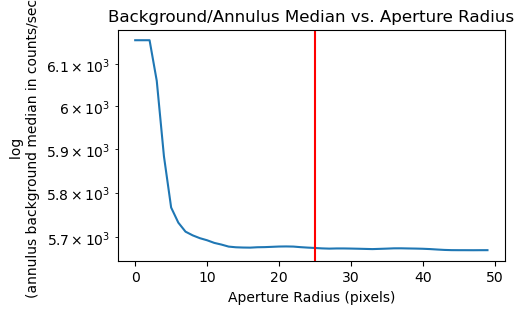

Brightness = 9.907829788793804e-17 W/ m^2 * micrometers


x-coordinate of center: 4278
y-coordinate of center: 3108


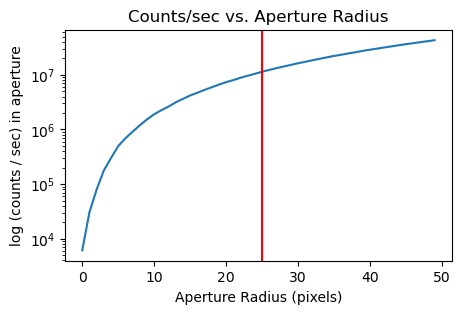

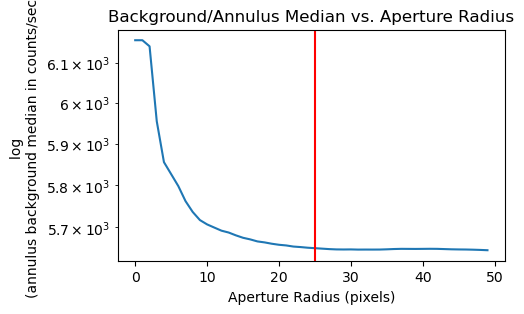

Brightness = 1.3804676132770695e-16 W/ m^2 * micrometers


x-coordinate of center: 4028
y-coordinate of center: 1697


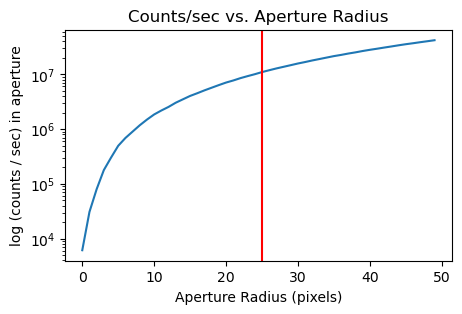

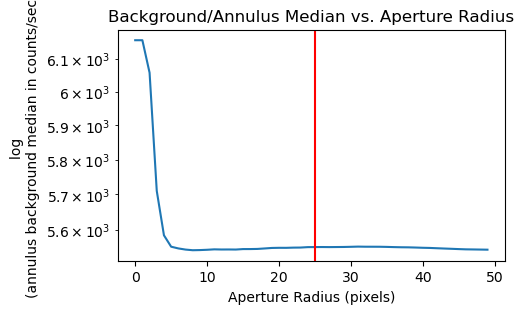

Brightness = 4.076708036601765e-17 W/ m^2 * micrometers


x-coordinate of center: 3830
y-coordinate of center: 1623


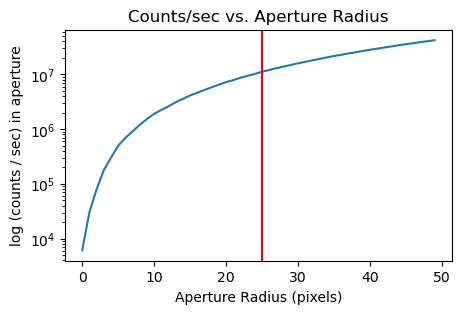

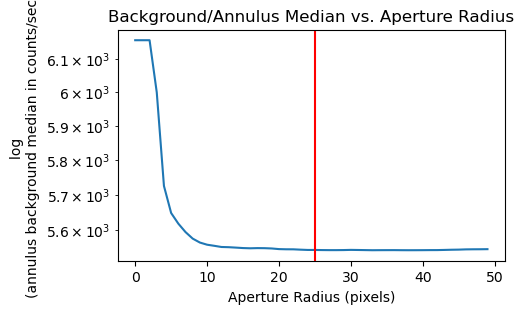

Brightness = 1.2561033210388057e-16 W/ m^2 * micrometers


x-coordinate of center: 3149
y-coordinate of center: 3854


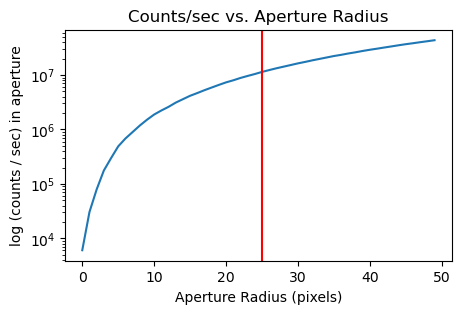

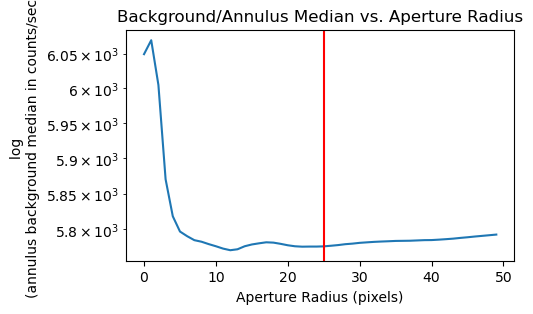

Brightness = 3.362970342534904e-17 W/ m^2 * micrometers




In [72]:
centers = []
brightness_i = []
for center_x, center_y in zip(star_x, star_y):
    width = 20

    zoomed = img[center_x - width:center_x + width, center_y-width:center_y + width]
    x_coord, y_coord = find_star_center(img, zoomed, range(center_x - width, center_x + width), range(center_y - width, center_y + width), plot_means=False)
    centers.append((x_coord, y_coord))
    
    distances = create_aperture(img, plot=False)

    n = 50
    optimal_r = 25

    aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
    plot_counts_v_radius(img, aperture_counts, annulus_counts, 25, n)

    counts, _ = calculate_brightness(optimal_r, i_flux, prnt=False)
    brightness = counts * i_cal
    brightness_i.append(brightness)

    print(f"Brightness = {brightness} W/ m^2 * micrometers\n\n")

In [ ]:
# brightness_i = [1.22198073042852e-16, 2.616917971130114e-16, 7.854649487062685e-17, 1.6452027406431902e-16, 6.323872855472384e-17, 3.1889957902977176e-17, 1.2712185474498508e-16, 4.977212928377625e-17, 4.0047201329603927e-17, 1.1385336123274495e-16, 1.654078282005977e-16, 1.1537476239400904e-16, 2.509433192083753e-17, 6.958544754232667e-17, 5.119442076610577e-17, 6.630276101390879e-17]



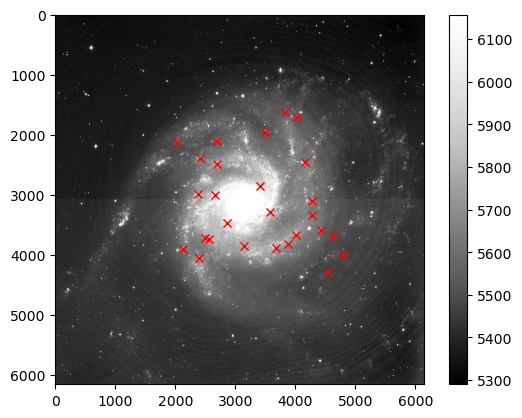

In [73]:
plt.figure()
plt.imshow(img, vmin=np.percentile(img, 1), vmax=np.percentile(img, 99), cmap='Greys_r')
plt.colorbar()
for x, y in centers:
    plt.plot(x, y, 'x', color='red')

## r' filter

In [74]:
fits_image_filename = 'analysis_imgs/r.fits'
data = fits.open(fits_image_filename)
img = data['PRIMARY'].data.astype('float')

x-coordinate of center: 2019
y-coordinate of center: 2114


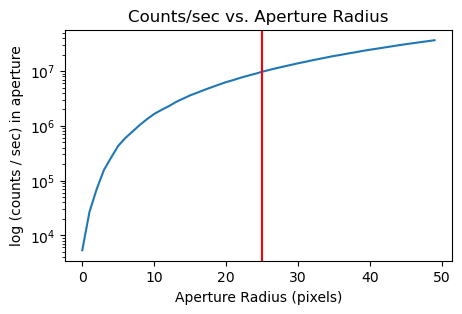

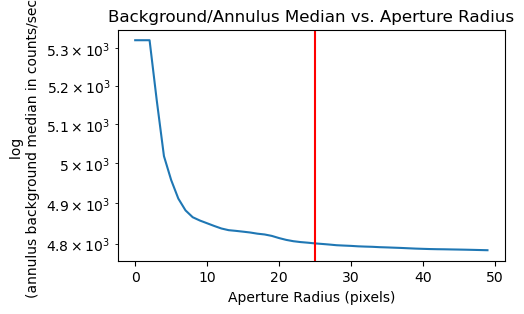

Brightness = 1.647846349254462e-16 W/ m^2 * micrometers


x-coordinate of center: 2418
y-coordinate of center: 2385


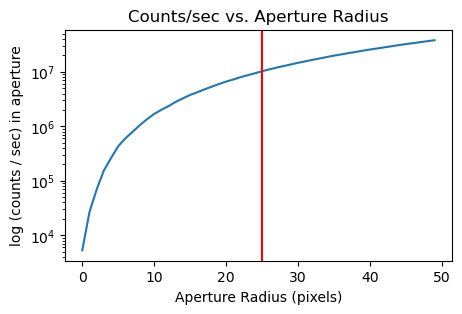

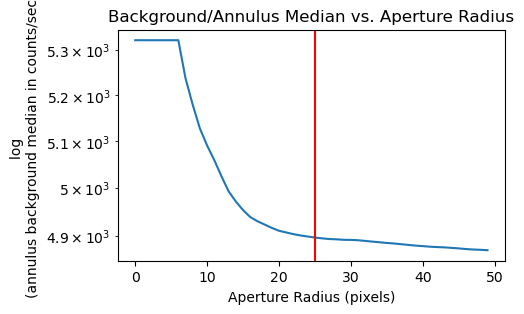

Brightness = 3.723923878071836e-16 W/ m^2 * micrometers


x-coordinate of center: 2697
y-coordinate of center: 2500


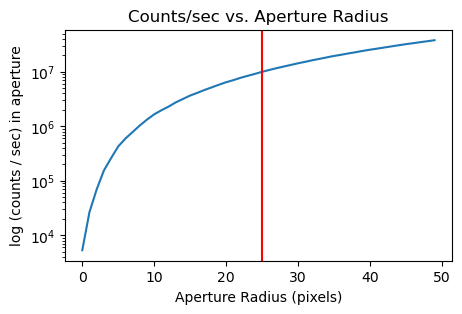

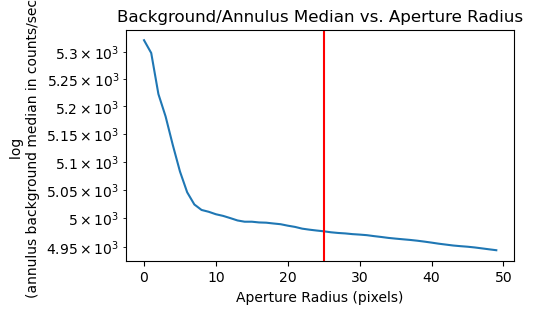

Brightness = 1.0668279837530828e-16 W/ m^2 * micrometers


x-coordinate of center: 2379
y-coordinate of center: 2980


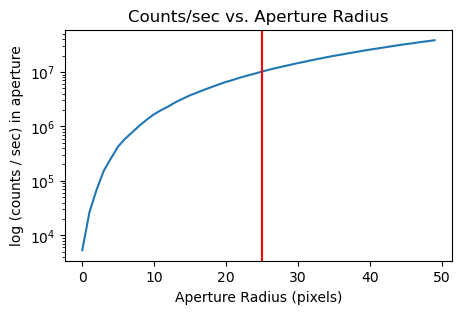

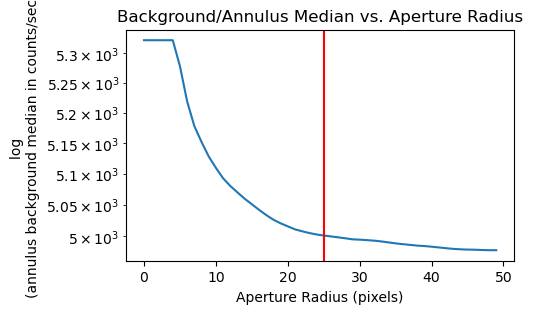

Brightness = 2.3155678649594316e-16 W/ m^2 * micrometers


x-coordinate of center: 2665
y-coordinate of center: 3002


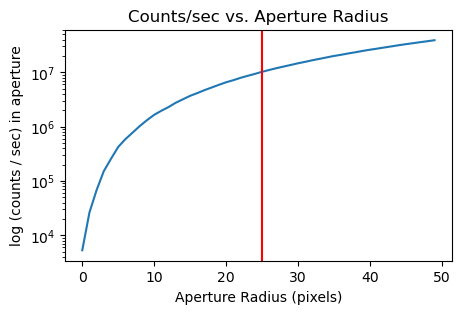

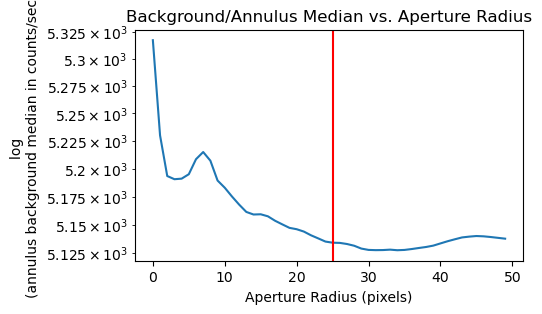

Brightness = 7.96030764733501e-17 W/ m^2 * micrometers


x-coordinate of center: 3567
y-coordinate of center: 3289


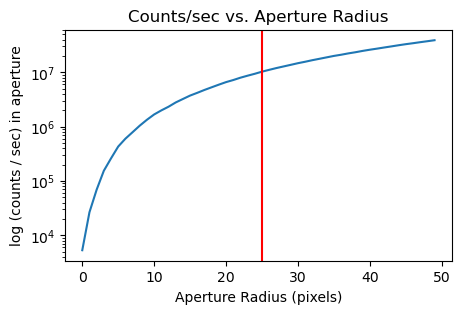

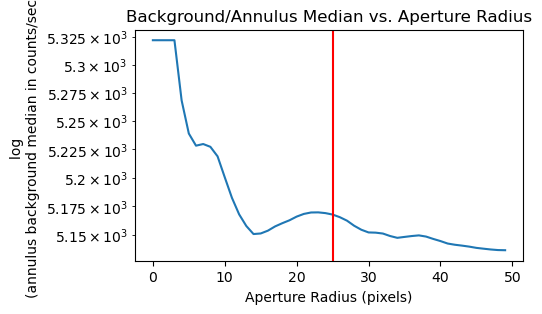

Brightness = 8.238788312589046e-17 W/ m^2 * micrometers


x-coordinate of center: 4007
y-coordinate of center: 3644


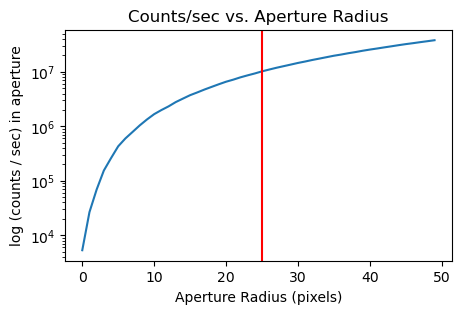

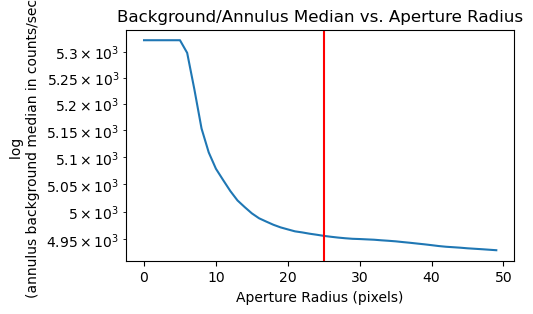

Brightness = 2.8295207568703106e-16 W/ m^2 * micrometers


x-coordinate of center: 3681
y-coordinate of center: 3886


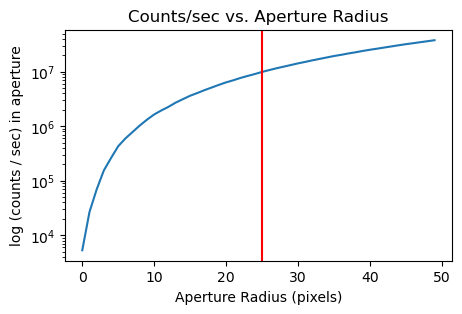

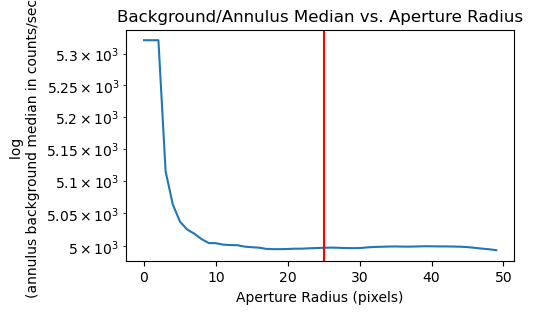

Brightness = 5.608382785459118e-17 W/ m^2 * micrometers


x-coordinate of center: 3874
y-coordinate of center: 3817


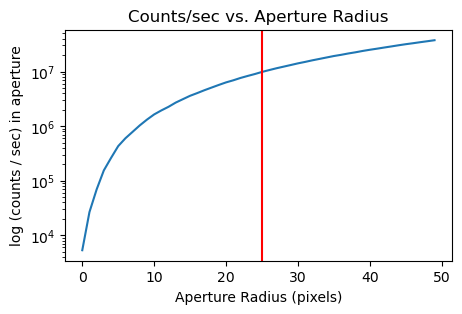

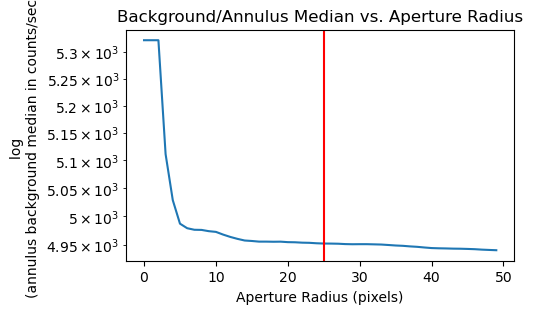

Brightness = 6.63753512528675e-17 W/ m^2 * micrometers


x-coordinate of center: 4274
y-coordinate of center: 3334


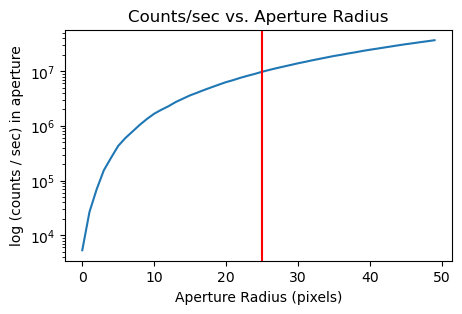

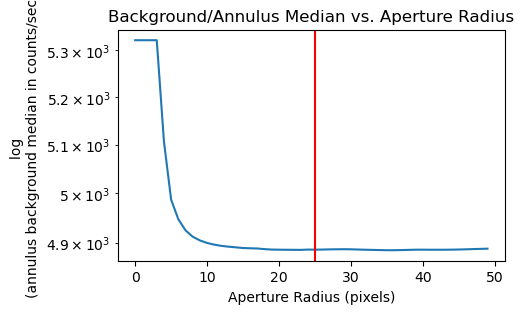

Brightness = 1.2106642292732658e-16 W/ m^2 * micrometers


x-coordinate of center: 4423
y-coordinate of center: 3578


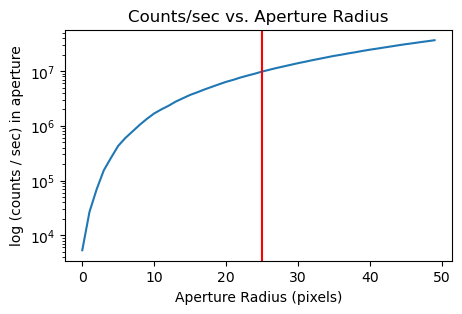

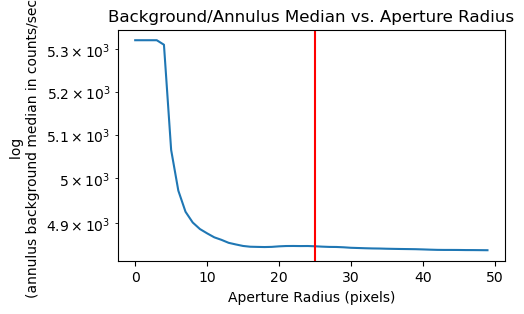

Brightness = 1.8582028716586857e-16 W/ m^2 * micrometers


x-coordinate of center: 4619
y-coordinate of center: 3692


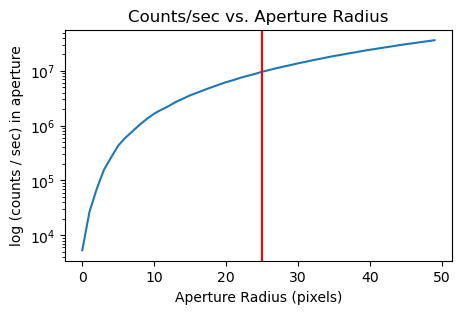

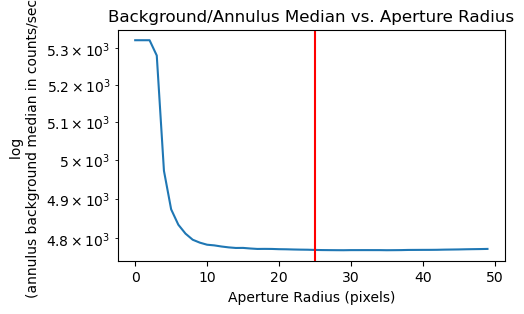

Brightness = 1.3276654599535754e-16 W/ m^2 * micrometers


x-coordinate of center: 4802
y-coordinate of center: 4005


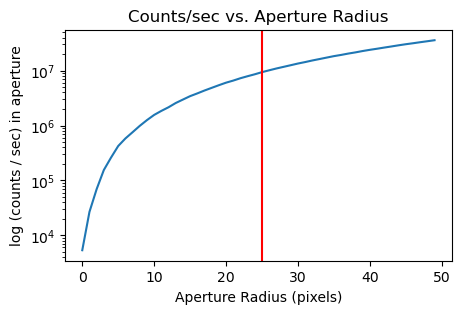

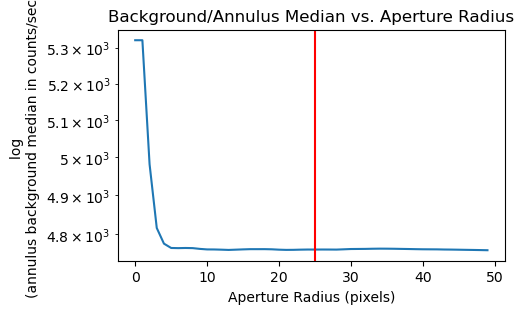

Brightness = 3.4614890385040423e-17 W/ m^2 * micrometers


x-coordinate of center: 4535
y-coordinate of center: 4282


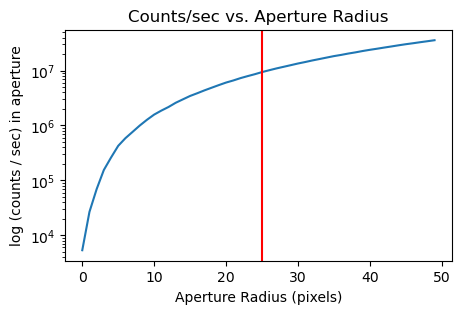

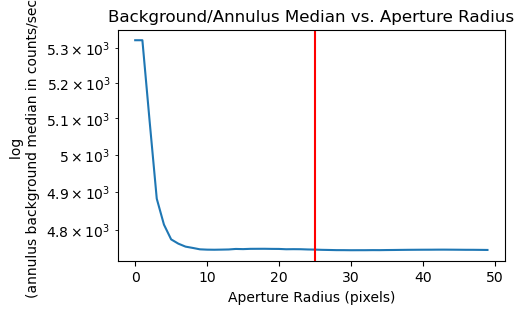

Brightness = 5.732298126252735e-17 W/ m^2 * micrometers


x-coordinate of center: 2573
y-coordinate of center: 3727


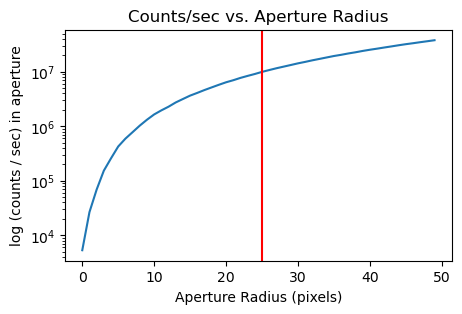

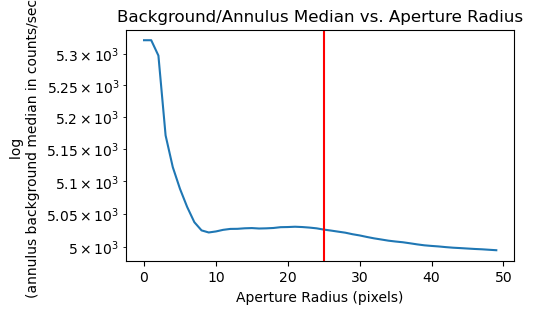

Brightness = 5.706401540774021e-17 W/ m^2 * micrometers


x-coordinate of center: 2863
y-coordinate of center: 3467


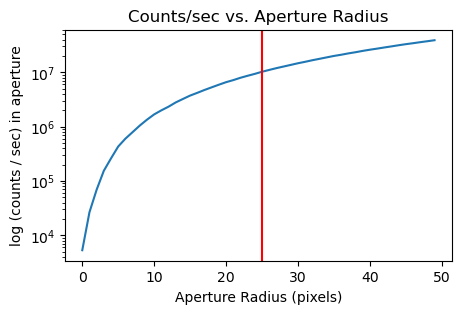

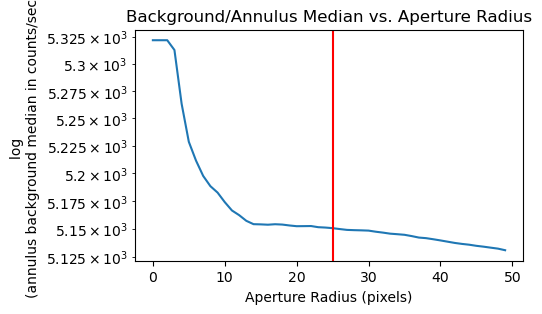

Brightness = 7.437148240806231e-17 W/ m^2 * micrometers


x-coordinate of center: 2697
y-coordinate of center: 2094


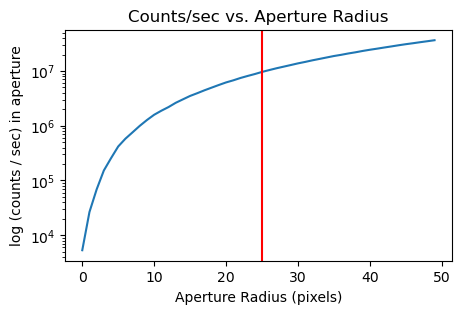

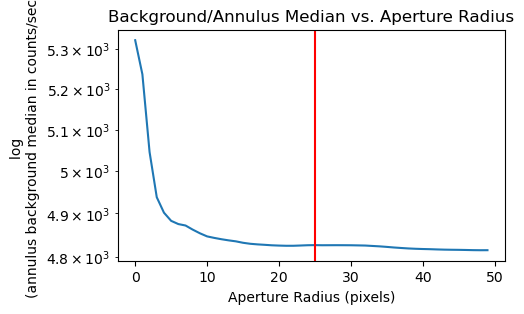

Brightness = 9.224841788549478e-17 W/ m^2 * micrometers


x-coordinate of center: 2129
y-coordinate of center: 3903


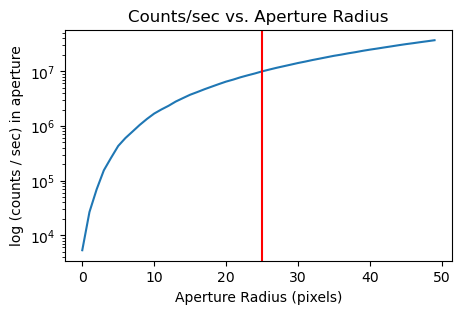

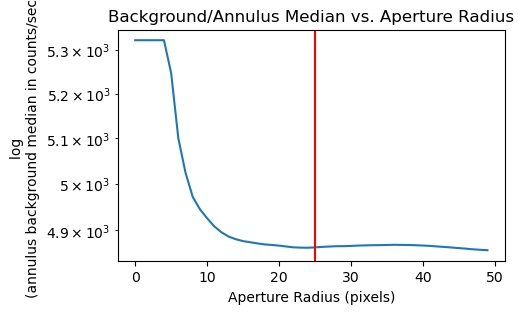

Brightness = 2.6452455053978116e-16 W/ m^2 * micrometers


x-coordinate of center: 4157
y-coordinate of center: 2457


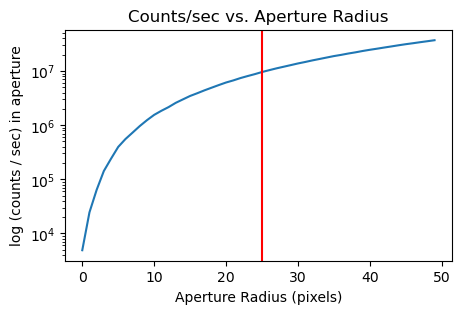

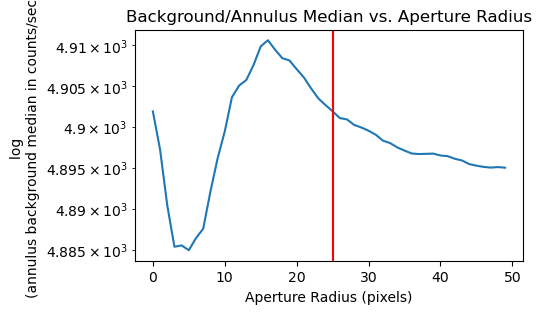

Brightness = -1.3606306262013677e-17 W/ m^2 * micrometers


x-coordinate of center: 3411
y-coordinate of center: 2849


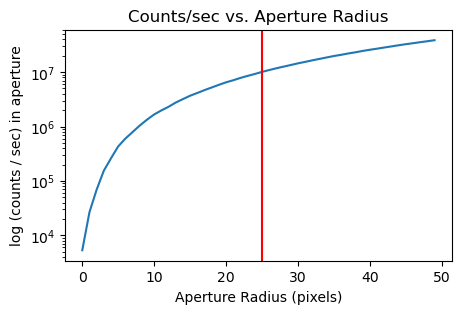

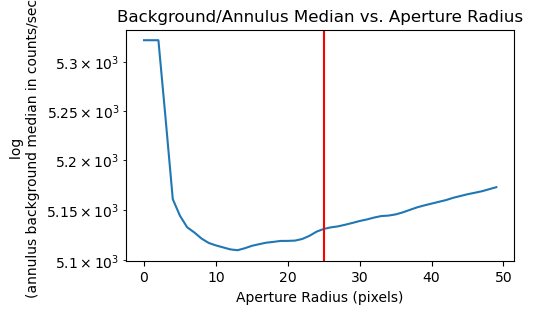

Brightness = 2.6572331079332537e-17 W/ m^2 * micrometers


x-coordinate of center: 2493
y-coordinate of center: 3719


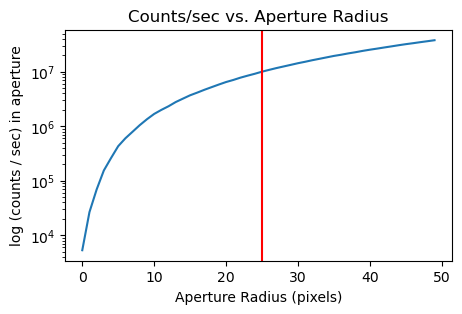

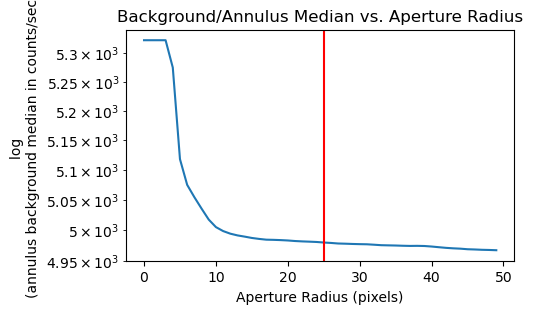

Brightness = 1.4531007168597172e-16 W/ m^2 * micrometers


x-coordinate of center: 3501
y-coordinate of center: 1944


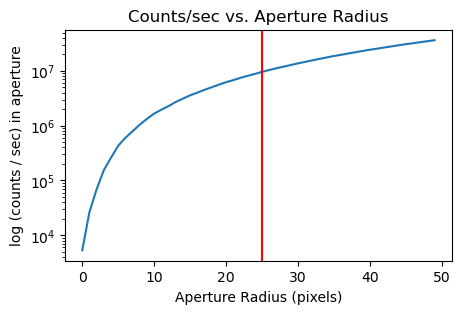

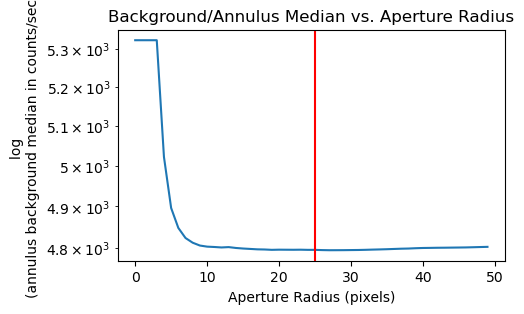

Brightness = 1.2948287969764e-16 W/ m^2 * micrometers


x-coordinate of center: 2397
y-coordinate of center: 4041


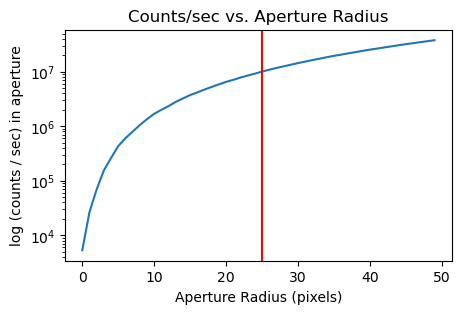

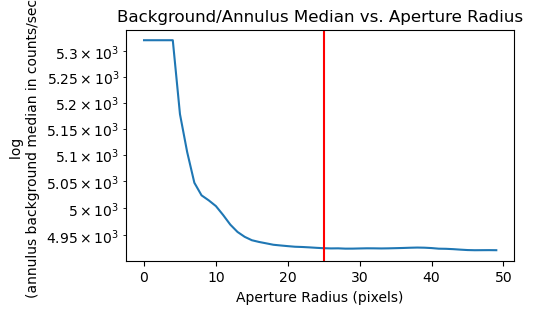

Brightness = 2.1381313793459042e-16 W/ m^2 * micrometers


x-coordinate of center: 4275
y-coordinate of center: 3102


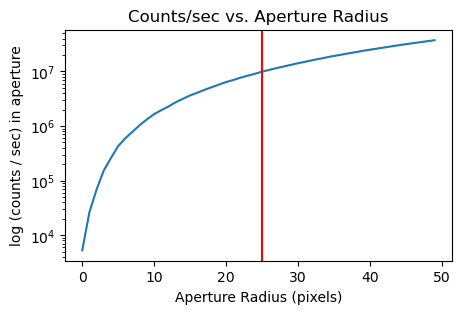

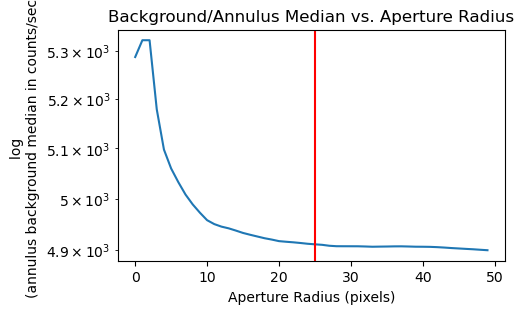

Brightness = 1.5071071775329735e-16 W/ m^2 * micrometers


x-coordinate of center: 4026
y-coordinate of center: 1692


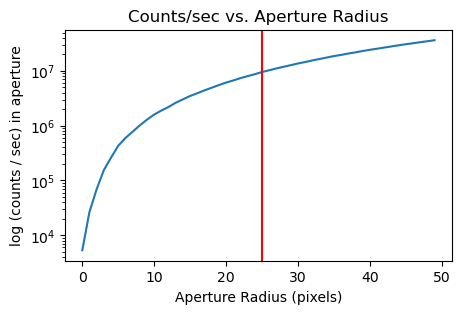

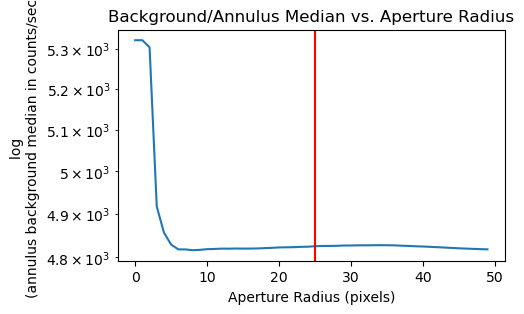

Brightness = 3.7886685021062965e-17 W/ m^2 * micrometers


x-coordinate of center: 3829
y-coordinate of center: 1616


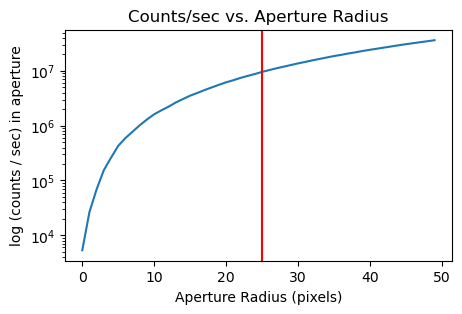

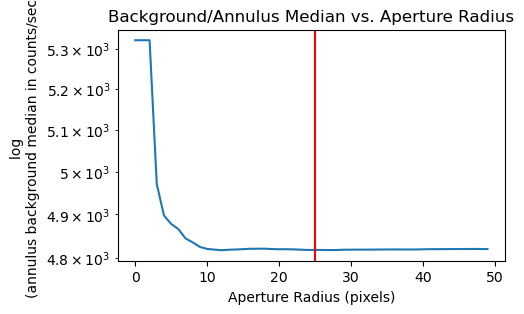

Brightness = 9.400535138395776e-17 W/ m^2 * micrometers


x-coordinate of center: 3147
y-coordinate of center: 3847


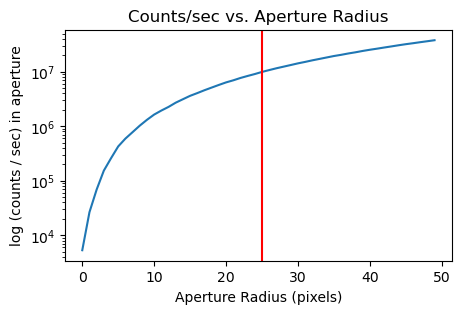

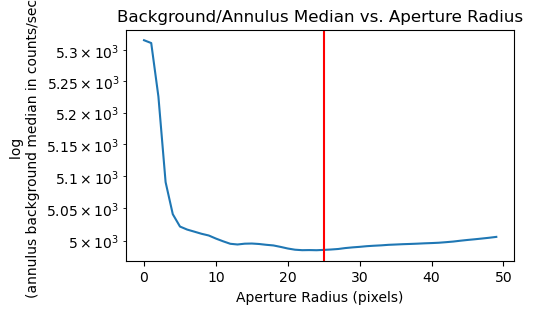

Brightness = 6.23020775975109e-17 W/ m^2 * micrometers




In [75]:
centers = []
brightness_r = []
for center_x, center_y in zip(star_x, star_y):
    width = 20

    zoomed = img[center_x - width:center_x + width, center_y-width:center_y + width]
    x_coord, y_coord = find_star_center(img, zoomed, range(center_x - width, center_x + width), range(center_y - width, center_y + width), plot_means=False)
    centers.append((x_coord, y_coord))
    
    distances = create_aperture(img, plot=False)

    n = 50
    optimal_r = 25

    aperture_counts, annulus_counts, n_pixels = calc_counts_v_radius(img, n)
    plot_counts_v_radius(img, aperture_counts, annulus_counts, 25, n)

    counts, _ = calculate_brightness(optimal_r, r_flux, prnt=False)
    brightness = counts * r_cal
    brightness_r.append(brightness)

    print(f"Brightness = {brightness} W/ m^2 * micrometers\n\n")
# brightness_r = calculate_star_flux(star_y, star_x, r_flux, r_cal, img)


/var/folders/7z/jfmx8yvn19d5mcq2xc1n5t2m0000gn/T/ipykernel_20198/3117791341.py:2: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux / F_0)


Text(0.5, 1.0, 'R-I Color-magnitude Diagram for Stars in M101')

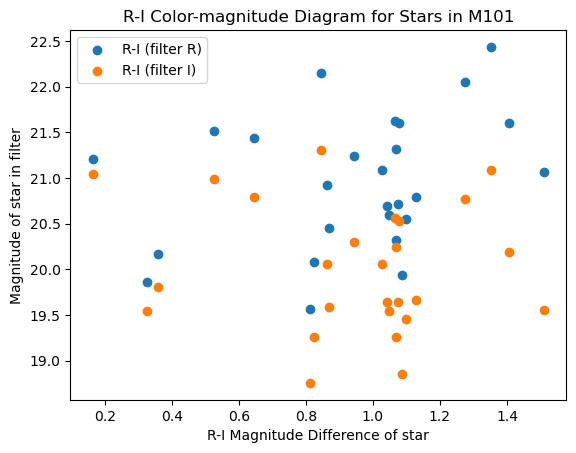

In [76]:
def flux_to_magnitude(flux, F_0):
    return -2.5 * np.log10(flux / F_0)

r_mags = flux_to_magnitude(np.array(brightness_r), f_0r)
i_mags = flux_to_magnitude(np.array(brightness_i), f_0i)
diffs = np.abs(r_mags - i_mags)

plt.scatter(diffs, r_mags)
plt.scatter(diffs, i_mags)
plt.xlabel("R-I Magnitude Difference of star")
plt.ylabel("Magnitude of star in filter")
plt.legend(labels=['R-I (filter R)', 'R-I (filter I)'])
plt.title("R-I Color-magnitude Diagram for Stars in M101")